In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_2_3_5_6_weight_2


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5296 - accuracy: 0.6666 - precision: 0.9562 - recall: 0.6591 - f1: 0.7675 - specificity: 0.7560 - negative_predictive_value: 0.2447 - matthews_correlation_coefficient: 0.2825 - val_loss: 0.5578 - val_accuracy: 0.6973 - val_precision: 0.9368 - val_recall: 0.6647 - val_f1: 0.7743 - val_specificity: 0.7873 - val_negative_predictive_value: 0.2712 - val_matthews_correlation_coefficient: 0.3012

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30119, saving model to ../models/autoencoders_requirements/blurred_2020_03_30-18_42_47.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4767 - accuracy: 0.7072 - precision: 0.9662 - recall: 0.6993 - f1: 0.8043 - specificity: 0.7542 - negative_predictive_value: 0.2566 - matthews_correlation_coefficient: 0.3129 - val_loss: 0.4916 - val_accuracy: 0.6843 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient improved from 0.38341 to 0.39193, saving model to ../models/autoencoders_requirements/blurred_2020_03_30-18_42_47.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4105 - accuracy: 0.7430 - precision: 0.9764 - recall: 0.7269 - f1: 0.8283 - specificity: 0.8566 - negative_predictive_value: 0.2979 - matthews_correlation_coefficient: 0.3914 - val_loss: 0.5366 - val_accuracy: 0.6895 - val_precision: 0.9558 - val_recall: 0.6438 - val_f1: 0.7662 - val_specificity: 0.8912 - val_negative_predictive_value: 0.2783 - val_matthews_correlation_coefficient: 0.3495

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39193
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4122 - accuracy: 0.7395 - precision: 0.9769 - recall: 0.7226 - f1: 0.8256 - specificity: 0.8543 - negative_predictive_value: 0.2957 - matthews_correlation_coefficient: 0.3899 - val_loss: 0.4825 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3978 - accuracy: 0.7540 - precision: 0.9787 - recall: 0.7417 - f1: 0.8385 - specificity: 0.8382 - negative_predictive_value: 0.3059 - matthews_correlation_coefficient: 0.3983 - val_loss: 0.3651 - val_accuracy: 0.8283 - val_precision: 0.9412 - val_recall: 0.8119 - val_f1: 0.8698 - val_specificity: 0.7806 - val_negative_predictive_value: 0.3928 - val_matthews_correlation_coefficient: 0.4363

Epoch 00029: val_matthews_correlation_coefficient improved from 0.43371 to 0.43634, saving model to ../models/autoencoders_requirements/blurred_2020_03_30-18_42_47.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3738 - accuracy: 0.7885 - precision: 0.9767 - recall: 0.7793 - f1: 0.8629 - specificity: 0.8558 - negative_predictive_value: 0.3400 - matthews_correlation_coefficient: 0.4428 - val_loss: 0.5657 - val_accuracy: 0.7346 - val_precision: 0.9557 - val_recall: 0.6937 - val_f1: 0.8007 - val_specific

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3663 - accuracy: 0.7909 - precision: 0.9797 - recall: 0.7821 - f1: 0.8671 - specificity: 0.8310 - negative_predictive_value: 0.3448 - matthews_correlation_coefficient: 0.4417 - val_loss: 0.4706 - val_accuracy: 0.7693 - val_precision: 0.9583 - val_recall: 0.7300 - val_f1: 0.8265 - val_specificity: 0.9047 - val_negative_predictive_value: 0.3450 - val_matthews_correlation_coefficient: 0.4322

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45732
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3643 - accuracy: 0.7896 - precision: 0.9847 - recall: 0.7766 - f1: 0.8652 - specificity: 0.8748 - negative_predictive_value: 0.3424 - matthews_correlation_coefficient: 0.4544 - val_loss: 0.3252 - val_accuracy: 0.8534 - val_precision: 0.9274 - val_recall: 0.8542 - val_f1: 0.8880 - val_specificity: 0.6620 - val_negative_predictive_value: 0.4286 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient improved from 0.45826 to 0.48588, saving model to ../models/autoencoders_requirements/blurred_2020_03_30-18_42_47.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3585 - accuracy: 0.7846 - precision: 0.9810 - recall: 0.7720 - f1: 0.8574 - specificity: 0.8612 - negative_predictive_value: 0.3515 - matthews_correlation_coefficient: 0.4555 - val_loss: 0.3570 - val_accuracy: 0.8283 - val_precision: 0.9472 - val_recall: 0.8071 - val_f1: 0.8700 - val_specificity: 0.8049 - val_negative_predictive_value: 0.4058 - val_matthews_correlation_coefficient: 0.4595

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48588
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3537 - accuracy: 0.7989 - precision: 0.9833 - recall: 0.7878 - f1: 0.8718 - specificity: 0.8783 - negative_predictive_value: 0.3532 - matthews_correlation_coefficient: 0.4640 - val_loss: 0.4484 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3306 - accuracy: 0.8130 - precision: 0.9843 - recall: 0.8031 - f1: 0.8818 - specificity: 0.8629 - negative_predictive_value: 0.3703 - matthews_correlation_coefficient: 0.4795 - val_loss: 0.3480 - val_accuracy: 0.8422 - val_precision: 0.9469 - val_recall: 0.8232 - val_f1: 0.8791 - val_specificity: 0.8103 - val_negative_predictive_value: 0.4279 - val_matthews_correlation_coefficient: 0.4772

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.49176
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3192 - accuracy: 0.8208 - precision: 0.9869 - recall: 0.8063 - f1: 0.8850 - specificity: 0.8856 - negative_predictive_value: 0.3819 - matthews_correlation_coefficient: 0.4999 - val_loss: 0.2950 - val_accuracy: 0.8716 - val_precision: 0.9275 - val_recall: 0.8754 - val_f1: 0.8994 - val_specificity: 0.6516 - val_negative_predictive_value: 0.4631 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.49668
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3144 - accuracy: 0.8234 - precision: 0.9855 - recall: 0.8139 - f1: 0.8886 - specificity: 0.8853 - negative_predictive_value: 0.3961 - matthews_correlation_coefficient: 0.5083 - val_loss: 0.3982 - val_accuracy: 0.8187 - val_precision: 0.9476 - val_recall: 0.7950 - val_f1: 0.8629 - val_specificity: 0.8202 - val_negative_predictive_value: 0.3914 - val_matthews_correlation_coefficient: 0.4525

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.49668
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3138 - accuracy: 0.8189 - precision: 0.9879 - recall: 0.8033 - f1: 0.8836 - specificity: 0.9019 - negative_predictive_value: 0.3750 - matthews_correlation_coefficient: 0.4981 - val_loss: 0.3093 - val_accuracy: 0.8682 - val_precision: 0.9371 - val_recall: 0.8623 - val_f1: 0.8966 - val_spe

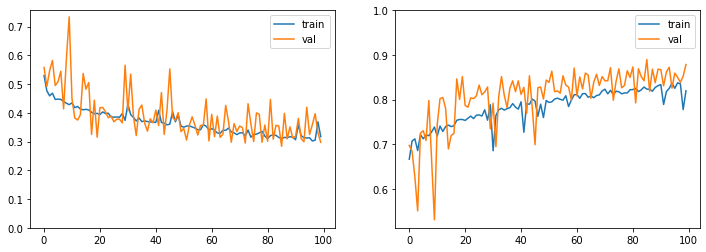

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6691 - accuracy: 0.5868 - precision: 0.7701 - recall: 0.5672 - f1: 0.6303 - specificity: 0.6148 - negative_predictive_value: 0.4047 - matthews_correlation_coefficient: 0.1835 - val_loss: 0.6636 - val_accuracy: 0.6618 - val_precision: 0.7692 - val_recall: 0.6754 - val_f1: 0.7147 - val_specificity: 0.6050 - val_negative_predictive_value: 0.4799 - val_matthews_correlation_coefficient: 0.2634

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26338, saving model to ../models/autoencoders_requirements/looking_away_2020_03_30-18_57_40.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6610 - accuracy: 0.6121 - precision: 0.7736 - recall: 0.6090 - f1: 0.6703 - specificity: 0.6177 - negative_predictive_value: 0.4252 - matthews_correlation_coefficient: 0.2134 - val_loss: 0.6981 - val_accuracy: 0.5594 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6119 - accuracy: 0.6748 - precision: 0.8271 - recall: 0.6769 - f1: 0.7349 - specificity: 0.6732 - negative_predictive_value: 0.4880 - matthews_correlation_coefficient: 0.3306 - val_loss: 0.5896 - val_accuracy: 0.6774 - val_precision: 0.7218 - val_recall: 0.8005 - val_f1: 0.7543 - val_specificity: 0.3561 - val_negative_predictive_value: 0.4743 - val_matthews_correlation_coefficient: 0.2002

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34563
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6151 - accuracy: 0.6733 - precision: 0.8211 - recall: 0.6805 - f1: 0.7353 - specificity: 0.6502 - negative_predictive_value: 0.4835 - matthews_correlation_coefficient: 0.3179 - val_loss: 0.5739 - val_accuracy: 0.6869 - val_precision: 0.7584 - val_recall: 0.7437 - val_f1: 0.7458 - val_specificity: 0.5110 - val_negative_predictive_value: 0.4966 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5903 - accuracy: 0.6902 - precision: 0.8233 - recall: 0.6979 - f1: 0.7442 - specificity: 0.6715 - negative_predictive_value: 0.5145 - matthews_correlation_coefficient: 0.3530 - val_loss: 0.6216 - val_accuracy: 0.6878 - val_precision: 0.8284 - val_recall: 0.6435 - val_f1: 0.7178 - val_specificity: 0.7560 - val_negative_predictive_value: 0.5179 - val_matthews_correlation_coefficient: 0.3708

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38864
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5746 - accuracy: 0.7004 - precision: 0.8376 - recall: 0.7074 - f1: 0.7598 - specificity: 0.6930 - negative_predictive_value: 0.5242 - matthews_correlation_coefficient: 0.3795 - val_loss: 0.6027 - val_accuracy: 0.6696 - val_precision: 0.8258 - val_recall: 0.6141 - val_f1: 0.7007 - val_specificity: 0.7594 - val_negative_predictive_value: 0.4908 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5597 - accuracy: 0.7048 - precision: 0.8436 - recall: 0.7083 - f1: 0.7619 - specificity: 0.7116 - negative_predictive_value: 0.5232 - matthews_correlation_coefficient: 0.3930 - val_loss: 0.5627 - val_accuracy: 0.7147 - val_precision: 0.8190 - val_recall: 0.7045 - val_f1: 0.7517 - val_specificity: 0.7124 - val_negative_predictive_value: 0.5496 - val_matthews_correlation_coefficient: 0.3907

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39528
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5587 - accuracy: 0.7171 - precision: 0.8445 - recall: 0.7246 - f1: 0.7739 - specificity: 0.7045 - negative_predictive_value: 0.5420 - matthews_correlation_coefficient: 0.4059 - val_loss: 0.7722 - val_accuracy: 0.5915 - val_precision: 0.8435 - val_recall: 0.4632 - val_f1: 0.5932 - val_specificity: 0.8502 - val_negative_predictive_value: 0.4380 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5490 - accuracy: 0.7148 - precision: 0.8496 - recall: 0.7141 - f1: 0.7692 - specificity: 0.7183 - negative_predictive_value: 0.5363 - matthews_correlation_coefficient: 0.4088 - val_loss: 0.5822 - val_accuracy: 0.6748 - val_precision: 0.8324 - val_recall: 0.6165 - val_f1: 0.7019 - val_specificity: 0.7680 - val_negative_predictive_value: 0.5015 - val_matthews_correlation_coefficient: 0.3571

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39528
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5517 - accuracy: 0.7195 - precision: 0.8504 - recall: 0.7290 - f1: 0.7752 - specificity: 0.7208 - negative_predictive_value: 0.5523 - matthews_correlation_coefficient: 0.4235 - val_loss: 0.7265 - val_accuracy: 0.6435 - val_precision: 0.8541 - val_recall: 0.5438 - val_f1: 0.6566 - val_specificity: 0.8320 - val_negative_predictive_value: 0.4771 - val_matthews_correlation_coefficie

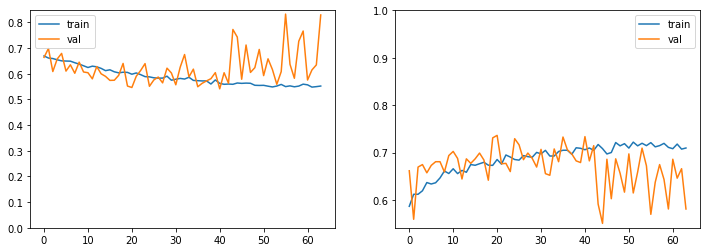

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6376 - accuracy: 0.6451 - precision: 0.6799 - recall: 0.6554 - f1: 0.6471 - specificity: 0.6355 - negative_predictive_value: 0.6174 - matthews_correlation_coefficient: 0.3016 - val_loss: 0.6038 - val_accuracy: 0.6748 - val_precision: 0.7762 - val_recall: 0.6148 - val_f1: 0.6794 - val_specificity: 0.7452 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.3594

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35936, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_30-19_07_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6068 - accuracy: 0.6792 - precision: 0.7215 - recall: 0.7150 - f1: 0.7005 - specificity: 0.6384 - negative_predictive_value: 0.6576 - matthews_correlation_coefficient: 0.3645 - val_loss: 0.5449 - val_accuracy: 0.7658 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5023 - accuracy: 0.7590 - precision: 0.7584 - recall: 0.8491 - f1: 0.7957 - specificity: 0.6494 - negative_predictive_value: 0.7763 - matthews_correlation_coefficient: 0.5154 - val_loss: 0.4648 - val_accuracy: 0.7823 - val_precision: 0.7883 - val_recall: 0.8553 - val_f1: 0.8168 - val_specificity: 0.6702 - val_negative_predictive_value: 0.7586 - val_matthews_correlation_coefficient: 0.5355

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.54559
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4988 - accuracy: 0.7644 - precision: 0.7690 - recall: 0.8404 - f1: 0.7968 - specificity: 0.6660 - negative_predictive_value: 0.7660 - matthews_correlation_coefficient: 0.5196 - val_loss: 0.4553 - val_accuracy: 0.7910 - val_precision: 0.7974 - val_recall: 0.8571 - val_f1: 0.8226 - val_specificity: 0.6883 - val_negative_predictive_value: 0.7666 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4579 - accuracy: 0.7872 - precision: 0.7856 - recall: 0.8537 - f1: 0.8126 - specificity: 0.7064 - negative_predictive_value: 0.7825 - matthews_correlation_coefficient: 0.5652 - val_loss: 0.4362 - val_accuracy: 0.8040 - val_precision: 0.8170 - val_recall: 0.8500 - val_f1: 0.8299 - val_specificity: 0.7267 - val_negative_predictive_value: 0.7708 - val_matthews_correlation_coefficient: 0.5816

Epoch 00029: val_matthews_correlation_coefficient improved from 0.57042 to 0.58165, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_30-19_07_11.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4608 - accuracy: 0.7813 - precision: 0.7869 - recall: 0.8467 - f1: 0.8111 - specificity: 0.6958 - negative_predictive_value: 0.7762 - matthews_correlation_coefficient: 0.5522 - val_loss: 0.4396 - val_accuracy: 0.7936 - val_precision: 0.8018 - val_recall: 0.8562 - val_f1: 0.8244 - 


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58165
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4407 - accuracy: 0.7902 - precision: 0.7955 - recall: 0.8332 - f1: 0.8092 - specificity: 0.7299 - negative_predictive_value: 0.7836 - matthews_correlation_coefficient: 0.5723 - val_loss: 0.5148 - val_accuracy: 0.7537 - val_precision: 0.8245 - val_recall: 0.7291 - val_f1: 0.7690 - val_specificity: 0.7761 - val_negative_predictive_value: 0.6685 - val_matthews_correlation_coefficient: 0.4987

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.58165
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4449 - accuracy: 0.7879 - precision: 0.8060 - recall: 0.8309 - f1: 0.8121 - specificity: 0.7335 - negative_predictive_value: 0.7693 - matthews_correlation_coefficient: 0.5692 - val_loss: 0.4397 - val_accuracy: 0.7962 - val_precision: 0.8147 - val_recall: 0.8423 - val_f1: 0.8247 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4436 - accuracy: 0.7976 - precision: 0.8049 - recall: 0.8466 - f1: 0.8193 - specificity: 0.7341 - negative_predictive_value: 0.7819 - matthews_correlation_coefficient: 0.5850 - val_loss: 0.4198 - val_accuracy: 0.8005 - val_precision: 0.8175 - val_recall: 0.8403 - val_f1: 0.8260 - val_specificity: 0.7290 - val_negative_predictive_value: 0.7597 - val_matthews_correlation_coefficient: 0.5728

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.59978
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4272 - accuracy: 0.7961 - precision: 0.8115 - recall: 0.8361 - f1: 0.8180 - specificity: 0.7459 - negative_predictive_value: 0.7730 - matthews_correlation_coefficient: 0.5846 - val_loss: 0.4520 - val_accuracy: 0.7892 - val_precision: 0.8261 - val_recall: 0.8067 - val_f1: 0.8132 - val_specificity: 0.7486 - val_negative_predictive_value: 0.7253 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4373 - accuracy: 0.7978 - precision: 0.8110 - recall: 0.8314 - f1: 0.8142 - specificity: 0.7471 - negative_predictive_value: 0.7799 - matthews_correlation_coefficient: 0.5911 - val_loss: 0.4518 - val_accuracy: 0.7788 - val_precision: 0.8211 - val_recall: 0.7220 - val_f1: 0.7644 - val_specificity: 0.8036 - val_negative_predictive_value: 0.6947 - val_matthews_correlation_coefficient: 0.5474

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.59978
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4277 - accuracy: 0.7961 - precision: 0.8156 - recall: 0.8182 - f1: 0.8098 - specificity: 0.7640 - negative_predictive_value: 0.7717 - matthews_correlation_coefficient: 0.5860 - val_loss: 0.5261 - val_accuracy: 0.7580 - val_precision: 0.8412 - val_recall: 0.7163 - val_f1: 0.7695 - val_specificity: 0.7994 - val_negative_predictive_value: 0.6638 - val_matthews_correlation_coefficie

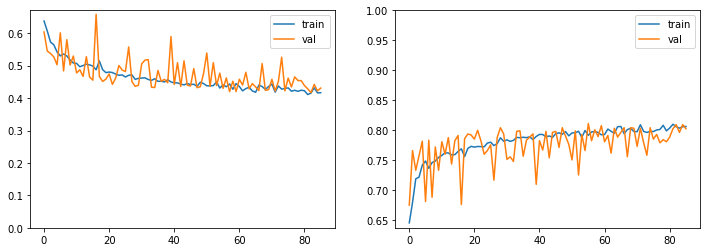

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5751 - accuracy: 0.7334 - precision: 0.9701 - recall: 0.7381 - f1: 0.8206 - specificity: 0.6509 - negative_predictive_value: 0.2339 - matthews_correlation_coefficient: 0.2795 - val_loss: 0.4160 - val_accuracy: 0.8552 - val_precision: 0.9484 - val_recall: 0.8406 - val_f1: 0.8891 - val_specificity: 0.7324 - val_negative_predictive_value: 0.3400 - val_matthews_correlation_coefficient: 0.3963

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39626, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_30-19_19_53.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4431 - accuracy: 0.8022 - precision: 0.9797 - recall: 0.8005 - f1: 0.8757 - specificity: 0.7061 - negative_predictive_value: 0.2803 - matthews_correlation_coefficient: 0.3578 - val_loss: 0.4115 - val_accuracy: 0.8248 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3292 - accuracy: 0.8681 - precision: 0.9864 - recall: 0.8703 - f1: 0.9228 - specificity: 0.7973 - negative_predictive_value: 0.3890 - matthews_correlation_coefficient: 0.4926 - val_loss: 0.6015 - val_accuracy: 0.7285 - val_precision: 0.9618 - val_recall: 0.6931 - val_f1: 0.8032 - val_specificity: 0.8851 - val_negative_predictive_value: 0.2295 - val_matthews_correlation_coefficient: 0.3263

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.42897
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3348 - accuracy: 0.8640 - precision: 0.9857 - recall: 0.8665 - f1: 0.9205 - specificity: 0.8132 - negative_predictive_value: 0.3695 - matthews_correlation_coefficient: 0.4806 - val_loss: 0.4911 - val_accuracy: 0.7944 - val_precision: 0.9594 - val_recall: 0.7659 - val_f1: 0.8493 - val_specificity: 0.8649 - val_negative_predictive_value: 0.2794 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43852
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2984 - accuracy: 0.8705 - precision: 0.9864 - recall: 0.8703 - f1: 0.9226 - specificity: 0.8092 - negative_predictive_value: 0.3906 - matthews_correlation_coefficient: 0.4944 - val_loss: 0.4202 - val_accuracy: 0.7927 - val_precision: 0.9600 - val_recall: 0.7645 - val_f1: 0.8486 - val_specificity: 0.8649 - val_negative_predictive_value: 0.2765 - val_matthews_correlation_coefficient: 0.3774

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.43852
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2967 - accuracy: 0.8774 - precision: 0.9895 - recall: 0.8779 - f1: 0.9289 - specificity: 0.8324 - negative_predictive_value: 0.3959 - matthews_correlation_coefficient: 0.5121 - val_loss: 0.3054 - val_accuracy: 0.8786 - val_precision: 0.9558 - val_recall: 0.8596 - val_f1: 0.9035 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49251
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2801 - accuracy: 0.8881 - precision: 0.9894 - recall: 0.8890 - f1: 0.9353 - specificity: 0.8324 - negative_predictive_value: 0.4151 - matthews_correlation_coefficient: 0.5293 - val_loss: 0.4068 - val_accuracy: 0.8135 - val_precision: 0.9590 - val_recall: 0.7871 - val_f1: 0.8625 - val_specificity: 0.8595 - val_negative_predictive_value: 0.2963 - val_matthews_correlation_coefficient: 0.3980

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.49251
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2919 - accuracy: 0.8794 - precision: 0.9883 - recall: 0.8808 - f1: 0.9300 - specificity: 0.8034 - negative_predictive_value: 0.3989 - matthews_correlation_coefficient: 0.5054 - val_loss: 0.6473 - val_accuracy: 0.7138 - val_precision: 0.9616 - val_recall: 0.6774 - val_f1: 0.7917 - val_spe


Epoch 00059: val_matthews_correlation_coefficient improved from 0.49251 to 0.49462, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_30-19_19_53.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2668 - accuracy: 0.8931 - precision: 0.9896 - recall: 0.8945 - f1: 0.9383 - specificity: 0.8394 - negative_predictive_value: 0.4412 - matthews_correlation_coefficient: 0.5507 - val_loss: 0.4529 - val_accuracy: 0.8153 - val_precision: 0.9566 - val_recall: 0.7907 - val_f1: 0.8632 - val_specificity: 0.8437 - val_negative_predictive_value: 0.3036 - val_matthews_correlation_coefficient: 0.3974

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.49462
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2611 - accuracy: 0.8822 - precision: 0.9901 - recall: 0.8821 - f1: 0.9308 - specificity: 0.8356 - negative_predictive_value: 0.4221 - matthews_correlation_coefficient: 0.5343 - val_loss: 0.4833


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.49462
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2480 - accuracy: 0.8961 - precision: 0.9903 - recall: 0.8969 - f1: 0.9404 - specificity: 0.8488 - negative_predictive_value: 0.4260 - matthews_correlation_coefficient: 0.5479 - val_loss: 0.6765 - val_accuracy: 0.7112 - val_precision: 0.9604 - val_recall: 0.6766 - val_f1: 0.7906 - val_specificity: 0.8829 - val_negative_predictive_value: 0.2250 - val_matthews_correlation_coefficient: 0.3145

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.49462
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2495 - accuracy: 0.8907 - precision: 0.9900 - recall: 0.8911 - f1: 0.9369 - specificity: 0.8351 - negative_predictive_value: 0.4151 - matthews_correlation_coefficient: 0.5330 - val_loss: 0.5308 - val_accuracy: 0.7736 - val_precision: 0.9597 - val_recall: 0.7451 - val_f1: 0.8358 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.49462
Epoch 00089: early stopping

   Final Accuracy:  88.46%
  Final Precision:  98.23%
     Final Recall:  89.06%
  Final F-measure:  93.42%
Final Specificity:  81.72%
        Final NPV:  39.58%
        Final MCC:  51.73%
[[ 76  17]
 [116 944]]
              precision    recall  f1-score   support

           0       0.40      0.82      0.53        93
           1       0.98      0.89      0.93      1060

    accuracy                           0.88      1153
   macro avg       0.69      0.85      0.73      1153
weighted avg       0.94      0.88      0.90      1153



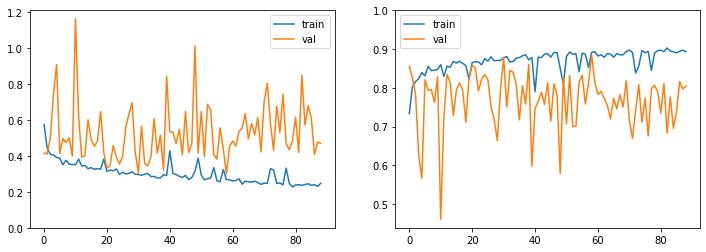

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5921 - accuracy: 0.7991 - precision: 0.9962 - recall: 0.7992 - f1: 0.8801 - specificity: 0.1460 - negative_predictive_value: 0.0221 - matthews_correlation_coefficient: 0.0457 - val_loss: 0.4673 - val_accuracy: 0.7008 - val_precision: 0.9730 - val_recall: 0.6798 - val_f1: 0.7977 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0257 - val_matthews_correlation_coefficient: 0.0620

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06203, saving model to ../models/autoencoders_requirements/washed_out_2020_03_30-19_33_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7347 - precision: 0.9989 - recall: 0.7320 - f1: 0.8334 - specificity: 0.2103 - negative_predictive_value: 0.0432 - matthews_correlation_coefficient: 0.0776 - val_loss: 0.3836 - val_accuracy: 0.7788 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.19072
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1221 - accuracy: 0.9492 - precision: 0.9996 - recall: 0.9464 - f1: 0.9706 - specificity: 0.2379 - negative_predictive_value: 0.1623 - matthews_correlation_coefficient: 0.1855 - val_loss: 0.1782 - val_accuracy: 0.9306 - val_precision: 0.9721 - val_recall: 0.9065 - val_f1: 0.9377 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0977 - val_matthews_correlation_coefficient: 0.1289

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.19072
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1524 - accuracy: 0.9252 - precision: 0.9996 - recall: 0.9253 - f1: 0.9580 - specificity: 0.2552 - negative_predictive_value: 0.1295 - matthews_correlation_coefficient: 0.1645 - val_loss: 0.0590 - val_accuracy: 0.9835 - val_precision: 0.9991 - val_recall: 0.9847 - val_f1: 0.9918 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.19605
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1999 - accuracy: 0.9334 - precision: 0.9996 - recall: 0.9338 - f1: 0.9623 - specificity: 0.2414 - negative_predictive_value: 0.1511 - matthews_correlation_coefficient: 0.1789 - val_loss: 0.0976 - val_accuracy: 0.9636 - val_precision: 0.9991 - val_recall: 0.9652 - val_f1: 0.9816 - val_specificity: 0.2027 - val_negative_predictive_value: 0.1396 - val_matthews_correlation_coefficient: 0.1615

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.19605
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0690 - accuracy: 0.9783 - precision: 0.9998 - recall: 0.9786 - f1: 0.9889 - specificity: 0.2138 - negative_predictive_value: 0.1776 - matthews_correlation_coefficient: 0.1911 - val_loss: 0.1013 - val_accuracy: 0.9644 - val_precision: 0.9991 - val_recall: 0.9660 - val_f1: 0.9820 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.19605
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0474 - accuracy: 0.9783 - precision: 1.0000 - recall: 0.9783 - f1: 0.9888 - specificity: 0.2690 - negative_predictive_value: 0.1943 - matthews_correlation_coefficient: 0.2222 - val_loss: 0.1174 - val_accuracy: 0.9636 - val_precision: 0.9721 - val_recall: 0.9389 - val_f1: 0.9550 - val_specificity: 0.2027 - val_negative_predictive_value: 0.1532 - val_matthews_correlation_coefficient: 0.1673

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.19605
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0648 - accuracy: 0.9685 - precision: 0.9998 - recall: 0.9687 - f1: 0.9834 - specificity: 0.2345 - negative_predictive_value: 0.1537 - matthews_correlation_coefficient: 0.1825 - val_loss: 0.0788 - val_accuracy: 0.9766 - val_precision: 0.9991 - val_recall: 0.9779 - val_f1: 0.9882 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0336 - accuracy: 0.9835 - precision: 1.0000 - recall: 0.9835 - f1: 0.9915 - specificity: 0.2483 - negative_predictive_value: 0.1903 - matthews_correlation_coefficient: 0.2127 - val_loss: 0.0607 - val_accuracy: 0.9827 - val_precision: 0.9991 - val_recall: 0.9838 - val_f1: 0.9913 - val_specificity: 0.2027 - val_negative_predictive_value: 0.1892 - val_matthews_correlation_coefficient: 0.1907

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1034 - accuracy: 0.9603 - precision: 0.9998 - recall: 0.9604 - f1: 0.9786 - specificity: 0.2552 - negative_predictive_value: 0.1723 - matthews_correlation_coefficient: 0.1982 - val_loss: 0.0530 - val_accuracy: 0.9827 - val_precision: 0.9991 - val_recall: 0.9839 - val_f1: 0.9913 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0292 - accuracy: 0.9857 - precision: 1.0000 - recall: 0.9857 - f1: 0.9927 - specificity: 0.2414 - negative_predictive_value: 0.2006 - matthews_correlation_coefficient: 0.2163 - val_loss: 0.0721 - val_accuracy: 0.9835 - val_precision: 0.9991 - val_recall: 0.9847 - val_f1: 0.9918 - val_specificity: 0.2027 - val_negative_predictive_value: 0.1982 - val_matthews_correlation_coefficient: 0.1961

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1237 - accuracy: 0.9610 - precision: 0.9998 - recall: 0.9611 - f1: 0.9792 - specificity: 0.2414 - negative_predictive_value: 0.1675 - matthews_correlation_coefficient: 0.1933 - val_loss: 0.0702 - val_accuracy: 0.9792 - val_precision: 0.9991 - val_recall: 0.9804 - val_f1: 0.9895 - val_spe

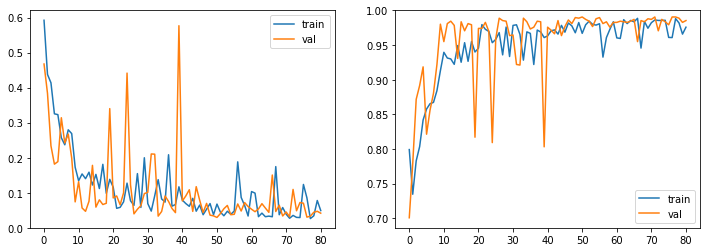

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6716 - accuracy: 0.5447 - precision: 0.9407 - recall: 0.5355 - f1: 0.6655 - specificity: 0.6054 - negative_predictive_value: 0.1041 - matthews_correlation_coefficient: 0.1124 - val_loss: 0.7307 - val_accuracy: 0.4866 - val_precision: 0.9718 - val_recall: 0.4753 - val_f1: 0.6302 - val_specificity: 0.6941 - val_negative_predictive_value: 0.0970 - val_matthews_correlation_coefficient: 0.1198

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11977, saving model to ../models/autoencoders_requirements/pixelation_2020_03_30-19_45_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6540 - accuracy: 0.5837 - precision: 0.9640 - recall: 0.5788 - f1: 0.7087 - specificity: 0.5994 - negative_predictive_value: 0.1070 - matthews_correlation_coefficient: 0.1252 - val_loss: 0.5472 - val_accuracy: 0.7155 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.21770
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5176 - accuracy: 0.7189 - precision: 0.9766 - recall: 0.7175 - f1: 0.8240 - specificity: 0.6800 - negative_predictive_value: 0.1668 - matthews_correlation_coefficient: 0.2405 - val_loss: 0.4234 - val_accuracy: 0.7572 - val_precision: 0.9656 - val_recall: 0.7715 - val_f1: 0.8557 - val_specificity: 0.5293 - val_negative_predictive_value: 0.1530 - val_matthews_correlation_coefficient: 0.1910

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.21770
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5257 - accuracy: 0.7041 - precision: 0.9760 - recall: 0.7025 - f1: 0.8137 - specificity: 0.6793 - negative_predictive_value: 0.1566 - matthews_correlation_coefficient: 0.2274 - val_loss: 0.3103 - val_accuracy: 0.8612 - val_precision: 0.9575 - val_recall: 0.8936 - val_f1: 0.9236 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22350
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4979 - accuracy: 0.7258 - precision: 0.9782 - recall: 0.7249 - f1: 0.8284 - specificity: 0.6866 - negative_predictive_value: 0.1779 - matthews_correlation_coefficient: 0.2533 - val_loss: 0.3663 - val_accuracy: 0.7936 - val_precision: 0.9665 - val_recall: 0.8107 - val_f1: 0.8798 - val_specificity: 0.5225 - val_negative_predictive_value: 0.1796 - val_matthews_correlation_coefficient: 0.2220

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22350
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4837 - accuracy: 0.7156 - precision: 0.9809 - recall: 0.7113 - f1: 0.8201 - specificity: 0.7253 - negative_predictive_value: 0.1722 - matthews_correlation_coefficient: 0.2580 - val_loss: 0.2508 - val_accuracy: 0.9098 - val_precision: 0.9532 - val_recall: 0.9514 - val_f1: 0.9519 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4806 - accuracy: 0.7239 - precision: 0.9813 - recall: 0.7165 - f1: 0.8245 - specificity: 0.7225 - negative_predictive_value: 0.1707 - matthews_correlation_coefficient: 0.2591 - val_loss: 0.3297 - val_accuracy: 0.8387 - val_precision: 0.9596 - val_recall: 0.8657 - val_f1: 0.9094 - val_specificity: 0.4104 - val_negative_predictive_value: 0.1898 - val_matthews_correlation_coefficient: 0.2029

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4821 - accuracy: 0.7267 - precision: 0.9738 - recall: 0.7167 - f1: 0.8228 - specificity: 0.6920 - negative_predictive_value: 0.1746 - matthews_correlation_coefficient: 0.2513 - val_loss: 0.5059 - val_accuracy: 0.7016 - val_precision: 0.9681 - val_recall: 0.7102 - val_f1: 0.8167 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4627 - accuracy: 0.7406 - precision: 0.9817 - recall: 0.7372 - f1: 0.8396 - specificity: 0.7459 - negative_predictive_value: 0.1894 - matthews_correlation_coefficient: 0.2847 - val_loss: 0.3897 - val_accuracy: 0.7572 - val_precision: 0.9658 - val_recall: 0.7717 - val_f1: 0.8561 - val_specificity: 0.5329 - val_negative_predictive_value: 0.1531 - val_matthews_correlation_coefficient: 0.1912

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4684 - accuracy: 0.7223 - precision: 0.9819 - recall: 0.7182 - f1: 0.8240 - specificity: 0.6791 - negative_predictive_value: 0.1789 - matthews_correlation_coefficient: 0.2580 - val_loss: 0.3851 - val_accuracy: 0.7771 - val_precision: 0.9699 - val_recall: 0.7894 - val_f1: 0.8686 - val_spe

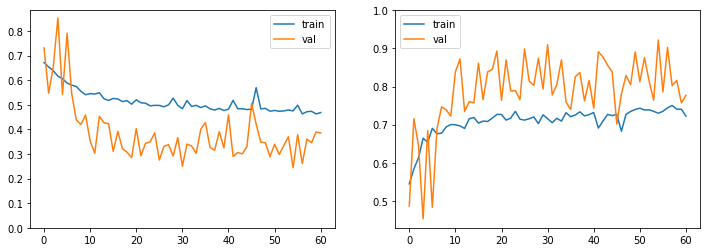

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5759 - accuracy: 0.6779 - precision: 0.9344 - recall: 0.6540 - f1: 0.7579 - specificity: 0.7756 - negative_predictive_value: 0.3245 - matthews_correlation_coefficient: 0.3351 - val_loss: 0.4704 - val_accuracy: 0.7069 - val_precision: 0.9202 - val_recall: 0.7119 - val_f1: 0.7987 - val_specificity: 0.7016 - val_negative_predictive_value: 0.3503 - val_matthews_correlation_coefficient: 0.3324

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33242, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_30-19_54_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.6948 - precision: 0.9480 - recall: 0.6627 - f1: 0.7761 - specificity: 0.8417 - negative_predictive_value: 0.3567 - matthews_correlation_coefficient: 0.3879 - val_loss: 0.6411 - val_accuracy: 0.6713 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4993 - accuracy: 0.7373 - precision: 0.9465 - recall: 0.7199 - f1: 0.8134 - specificity: 0.8081 - negative_predictive_value: 0.3979 - matthews_correlation_coefficient: 0.4228 - val_loss: 0.5757 - val_accuracy: 0.6904 - val_precision: 0.9547 - val_recall: 0.6644 - val_f1: 0.7783 - val_specificity: 0.8429 - val_negative_predictive_value: 0.3525 - val_matthews_correlation_coefficient: 0.3916

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40537
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4947 - accuracy: 0.7427 - precision: 0.9497 - recall: 0.7288 - f1: 0.8202 - specificity: 0.8281 - negative_predictive_value: 0.4118 - matthews_correlation_coefficient: 0.4425 - val_loss: 0.6323 - val_accuracy: 0.6687 - val_precision: 0.9573 - val_recall: 0.6356 - val_f1: 0.7583 - val_specificity: 0.8564 - val_negative_predictive_value: 0.3385 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43658
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4728 - accuracy: 0.7605 - precision: 0.9481 - recall: 0.7501 - f1: 0.8336 - specificity: 0.8060 - negative_predictive_value: 0.4213 - matthews_correlation_coefficient: 0.4488 - val_loss: 0.4739 - val_accuracy: 0.7624 - val_precision: 0.9360 - val_recall: 0.7713 - val_f1: 0.8419 - val_specificity: 0.7412 - val_negative_predictive_value: 0.4122 - val_matthews_correlation_coefficient: 0.4185

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.43658
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4774 - accuracy: 0.7627 - precision: 0.9477 - recall: 0.7543 - f1: 0.8351 - specificity: 0.8129 - negative_predictive_value: 0.4381 - matthews_correlation_coefficient: 0.4620 - val_loss: 0.5369 - val_accuracy: 0.7129 - val_precision: 0.9536 - val_recall: 0.6949 - val_f1: 0.7982 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43658
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4642 - accuracy: 0.7681 - precision: 0.9456 - recall: 0.7607 - f1: 0.8389 - specificity: 0.7816 - negative_predictive_value: 0.4324 - matthews_correlation_coefficient: 0.4500 - val_loss: 0.5011 - val_accuracy: 0.7554 - val_precision: 0.9343 - val_recall: 0.7645 - val_f1: 0.8370 - val_specificity: 0.7333 - val_negative_predictive_value: 0.4073 - val_matthews_correlation_coefficient: 0.4085

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.43658
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4532 - accuracy: 0.7753 - precision: 0.9481 - recall: 0.7700 - f1: 0.8465 - specificity: 0.8090 - negative_predictive_value: 0.4479 - matthews_correlation_coefficient: 0.4741 - val_loss: 0.5649 - val_accuracy: 0.7051 - val_precision: 0.9532 - val_recall: 0.6837 - val_f1: 0.7905 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43723
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4469 - accuracy: 0.7774 - precision: 0.9446 - recall: 0.7744 - f1: 0.8462 - specificity: 0.8062 - negative_predictive_value: 0.4482 - matthews_correlation_coefficient: 0.4734 - val_loss: 0.4426 - val_accuracy: 0.7771 - val_precision: 0.9276 - val_recall: 0.8008 - val_f1: 0.8556 - val_specificity: 0.6891 - val_negative_predictive_value: 0.4228 - val_matthews_correlation_coefficient: 0.4098

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.43723
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4552 - accuracy: 0.7670 - precision: 0.9509 - recall: 0.7575 - f1: 0.8393 - specificity: 0.8184 - negative_predictive_value: 0.4439 - matthews_correlation_coefficient: 0.4724 - val_loss: 0.5325 - val_accuracy: 0.7285 - val_precision: 0.9412 - val_recall: 0.7220 - val_f1: 0.8131 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.44510
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4341 - accuracy: 0.7803 - precision: 0.9436 - recall: 0.7776 - f1: 0.8473 - specificity: 0.7973 - negative_predictive_value: 0.4489 - matthews_correlation_coefficient: 0.4718 - val_loss: 0.4390 - val_accuracy: 0.7849 - val_precision: 0.9309 - val_recall: 0.8075 - val_f1: 0.8609 - val_specificity: 0.7046 - val_negative_predictive_value: 0.4466 - val_matthews_correlation_coefficient: 0.4347

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.44510
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4391 - accuracy: 0.7692 - precision: 0.9444 - recall: 0.7534 - f1: 0.8339 - specificity: 0.8117 - negative_predictive_value: 0.4412 - matthews_correlation_coefficient: 0.4628 - val_loss: 0.5510 - val_accuracy: 0.7181 - val_precision: 0.9528 - val_recall: 0.7006 - val_f1: 0.8019 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.44574
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4209 - accuracy: 0.7829 - precision: 0.9517 - recall: 0.7734 - f1: 0.8502 - specificity: 0.8124 - negative_predictive_value: 0.4517 - matthews_correlation_coefficient: 0.4830 - val_loss: 0.4644 - val_accuracy: 0.7667 - val_precision: 0.9463 - val_recall: 0.7668 - val_f1: 0.8432 - val_specificity: 0.7818 - val_negative_predictive_value: 0.4216 - val_matthews_correlation_coefficient: 0.4454

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.44574
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4178 - accuracy: 0.7961 - precision: 0.9541 - recall: 0.7874 - f1: 0.8576 - specificity: 0.8222 - negative_predictive_value: 0.4838 - matthews_correlation_coefficient: 0.5128 - val_loss: 0.4803 - val_accuracy: 0.7459 - val_precision: 0.9464 - val_recall: 0.7408 - val_f1: 0.8257 - val_spe

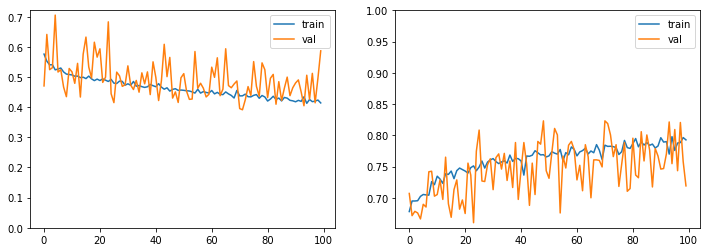

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 55s 12ms/step - loss: 0.6360 - accuracy: 0.5351 - precision: 0.9137 - recall: 0.4632 - f1: 0.6007 - specificity: 0.8134 - negative_predictive_value: 0.2773 - matthews_correlation_coefficient: 0.2322 - val_loss: 0.6012 - val_accuracy: 0.5629 - val_precision: 0.8985 - val_recall: 0.5215 - val_f1: 0.6509 - val_specificity: 0.7568 - val_negative_predictive_value: 0.2900 - val_matthews_correlation_coefficient: 0.2278

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22781, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_30-20_08_52.h5
Epoch 2/100
4610/4610 [==============================] - 49s 11ms/step - loss: 0.6312 - accuracy: 0.5434 - precision: 0.9100 - recall: 0.4754 - f1: 0.6121 - specificity: 0.8091 - negative_predictive_value: 0.2904 - matthews_correlation_coefficient: 0.2367 - val_loss: 0.7024 - val_accuracy: 0.4961 - val_precis

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5870 - accuracy: 0.6356 - precision: 0.9114 - recall: 0.6054 - f1: 0.7152 - specificity: 0.7563 - negative_predictive_value: 0.3425 - matthews_correlation_coefficient: 0.2997 - val_loss: 0.5369 - val_accuracy: 0.7069 - val_precision: 0.8946 - val_recall: 0.7252 - val_f1: 0.7977 - val_specificity: 0.6422 - val_negative_predictive_value: 0.3734 - val_matthews_correlation_coefficient: 0.3121

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.32370
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5837 - accuracy: 0.6566 - precision: 0.9165 - recall: 0.6267 - f1: 0.7318 - specificity: 0.7730 - negative_predictive_value: 0.3697 - matthews_correlation_coefficient: 0.3354 - val_loss: 0.5265 - val_accuracy: 0.7129 - val_precision: 0.8905 - val_recall: 0.7379 - val_f1: 0.8035 - val_specificity: 0.6355 - val_negative_predictive_value: 0.3812 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.35231
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5420 - accuracy: 0.6944 - precision: 0.9263 - recall: 0.6660 - f1: 0.7683 - specificity: 0.7880 - negative_predictive_value: 0.3809 - matthews_correlation_coefficient: 0.3709 - val_loss: 0.5184 - val_accuracy: 0.7363 - val_precision: 0.9067 - val_recall: 0.7548 - val_f1: 0.8204 - val_specificity: 0.6730 - val_negative_predictive_value: 0.4046 - val_matthews_correlation_coefficient: 0.3632

Epoch 00029: val_matthews_correlation_coefficient improved from 0.35231 to 0.36315, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_30-20_08_52.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5432 - accuracy: 0.6948 - precision: 0.9247 - recall: 0.6736 - f1: 0.7724 - specificity: 0.7747 - negative_predictive_value: 0.3877 - matthews_correlation_coefficient: 0.3716 - val_loss: 0.6684 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5167 - accuracy: 0.7158 - precision: 0.9253 - recall: 0.7007 - f1: 0.7922 - specificity: 0.7842 - negative_predictive_value: 0.4104 - matthews_correlation_coefficient: 0.4003 - val_loss: 0.5427 - val_accuracy: 0.7008 - val_precision: 0.9071 - val_recall: 0.7047 - val_f1: 0.7888 - val_specificity: 0.7001 - val_negative_predictive_value: 0.3722 - val_matthews_correlation_coefficient: 0.3347

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.37232
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5223 - accuracy: 0.7085 - precision: 0.9230 - recall: 0.6957 - f1: 0.7870 - specificity: 0.7624 - negative_predictive_value: 0.4014 - matthews_correlation_coefficient: 0.3825 - val_loss: 0.7065 - val_accuracy: 0.6071 - val_precision: 0.9433 - val_recall: 0.5504 - val_f1: 0.6863 - val_specificity: 0.8491 - val_negative_predictive_value: 0.3265 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5063 - accuracy: 0.7178 - precision: 0.9315 - recall: 0.6934 - f1: 0.7893 - specificity: 0.8018 - negative_predictive_value: 0.4117 - matthews_correlation_coefficient: 0.4107 - val_loss: 0.6534 - val_accuracy: 0.6574 - val_precision: 0.9349 - val_recall: 0.6229 - val_f1: 0.7409 - val_specificity: 0.8000 - val_negative_predictive_value: 0.3534 - val_matthews_correlation_coefficient: 0.3472

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.37232
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5127 - accuracy: 0.7271 - precision: 0.9172 - recall: 0.7119 - f1: 0.7953 - specificity: 0.7766 - negative_predictive_value: 0.4332 - matthews_correlation_coefficient: 0.4109 - val_loss: 0.5444 - val_accuracy: 0.6956 - val_precision: 0.9224 - val_recall: 0.6852 - val_f1: 0.7817 - val_specificity: 0.7472 - val_negative_predictive_value: 0.3762 - val_matthews_correlation_coefficie

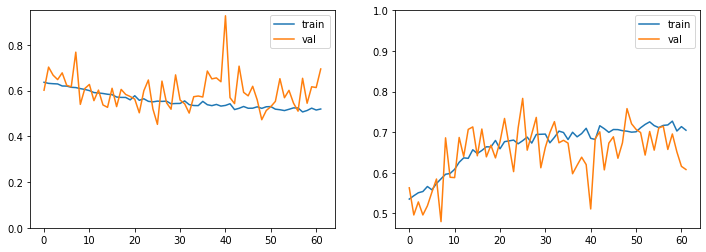

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5013 - accuracy: 0.7310 - precision: 0.7814 - recall: 0.7093 - f1: 0.7178 - specificity: 0.7582 - negative_predictive_value: 0.7143 - matthews_correlation_coefficient: 0.4814 - val_loss: 0.5428 - val_accuracy: 0.7103 - val_precision: 0.9273 - val_recall: 0.4895 - val_f1: 0.6328 - val_specificity: 0.9413 - val_negative_predictive_value: 0.5914 - val_matthews_correlation_coefficient: 0.4969

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.49689, saving model to ../models/autoencoders_requirements/varied_background_2020_03_30-20_23_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7727 - precision: 0.8278 - recall: 0.7654 - f1: 0.7809 - specificity: 0.7906 - negative_predictive_value: 0.7371 - matthews_correlation_coefficient: 0.5614 - val_loss: 0.3739 - val_accuracy: 0.8057 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.68271
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3427 - accuracy: 0.8249 - precision: 0.8637 - recall: 0.8206 - f1: 0.8336 - specificity: 0.8352 - negative_predictive_value: 0.7850 - matthews_correlation_coefficient: 0.6535 - val_loss: 0.3159 - val_accuracy: 0.8465 - val_precision: 0.8759 - val_recall: 0.7924 - val_f1: 0.8282 - val_specificity: 0.8621 - val_negative_predictive_value: 0.7712 - val_matthews_correlation_coefficient: 0.6774

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.68271
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3501 - accuracy: 0.8232 - precision: 0.8691 - recall: 0.8216 - f1: 0.8359 - specificity: 0.8356 - negative_predictive_value: 0.7803 - matthews_correlation_coefficient: 0.6527 - val_loss: 0.3040 - val_accuracy: 0.8612 - val_precision: 0.8411 - val_recall: 0.8693 - val_f1: 0.8524 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3168 - accuracy: 0.8473 - precision: 0.8751 - recall: 0.8393 - f1: 0.8522 - specificity: 0.8494 - negative_predictive_value: 0.8185 - matthews_correlation_coefficient: 0.6926 - val_loss: 0.3065 - val_accuracy: 0.8543 - val_precision: 0.8828 - val_recall: 0.7982 - val_f1: 0.8351 - val_specificity: 0.8716 - val_negative_predictive_value: 0.7797 - val_matthews_correlation_coefficient: 0.6928

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.70855
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3182 - accuracy: 0.8406 - precision: 0.8845 - recall: 0.8339 - f1: 0.8522 - specificity: 0.8651 - negative_predictive_value: 0.8012 - matthews_correlation_coefficient: 0.6920 - val_loss: 0.3010 - val_accuracy: 0.8560 - val_precision: 0.8461 - val_recall: 0.8478 - val_f1: 0.8446 - val_specificity: 0.8148 - val_negative_predictive_value: 0.8133 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72821
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3034 - accuracy: 0.8521 - precision: 0.8759 - recall: 0.8565 - f1: 0.8611 - specificity: 0.8483 - negative_predictive_value: 0.8198 - matthews_correlation_coefficient: 0.7014 - val_loss: 0.2734 - val_accuracy: 0.8742 - val_precision: 0.8608 - val_recall: 0.8672 - val_f1: 0.8616 - val_specificity: 0.8318 - val_negative_predictive_value: 0.8366 - val_matthews_correlation_coefficient: 0.7250

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.72821
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2991 - accuracy: 0.8542 - precision: 0.8886 - recall: 0.8446 - f1: 0.8612 - specificity: 0.8627 - negative_predictive_value: 0.8136 - matthews_correlation_coefficient: 0.7061 - val_loss: 0.2799 - val_accuracy: 0.8708 - val_precision: 0.8688 - val_recall: 0.8534 - val_f1: 0.8588 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2953 - accuracy: 0.8633 - precision: 0.9026 - recall: 0.8532 - f1: 0.8722 - specificity: 0.8743 - negative_predictive_value: 0.8216 - matthews_correlation_coefficient: 0.7255 - val_loss: 0.3081 - val_accuracy: 0.8508 - val_precision: 0.8140 - val_recall: 0.9621 - val_f1: 0.8787 - val_specificity: 0.6958 - val_negative_predictive_value: 0.9046 - val_matthews_correlation_coefficient: 0.6866

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73538
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2964 - accuracy: 0.8584 - precision: 0.8780 - recall: 0.8568 - f1: 0.8622 - specificity: 0.8632 - negative_predictive_value: 0.8314 - matthews_correlation_coefficient: 0.7142 - val_loss: 0.2772 - val_accuracy: 0.8690 - val_precision: 0.8549 - val_recall: 0.9300 - val_f1: 0.8885 - val_specificity: 0.7729 - val_negative_predictive_value: 0.8695 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.74150
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2802 - accuracy: 0.8638 - precision: 0.8847 - recall: 0.8583 - f1: 0.8667 - specificity: 0.8642 - negative_predictive_value: 0.8395 - matthews_correlation_coefficient: 0.7248 - val_loss: 0.2525 - val_accuracy: 0.8742 - val_precision: 0.8951 - val_recall: 0.8843 - val_f1: 0.8877 - val_specificity: 0.8430 - val_negative_predictive_value: 0.8244 - val_matthews_correlation_coefficient: 0.7232

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.74150
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2788 - accuracy: 0.8627 - precision: 0.8952 - recall: 0.8539 - f1: 0.8689 - specificity: 0.8703 - negative_predictive_value: 0.8254 - matthews_correlation_coefficient: 0.7236 - val_loss: 0.2791 - val_accuracy: 0.8656 - val_precision: 0.8598 - val_recall: 0.9156 - val_f1: 0.8845 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2613 - accuracy: 0.8753 - precision: 0.8996 - recall: 0.8776 - f1: 0.8853 - specificity: 0.8777 - negative_predictive_value: 0.8481 - matthews_correlation_coefficient: 0.7512 - val_loss: 0.3388 - val_accuracy: 0.8491 - val_precision: 0.8125 - val_recall: 0.9613 - val_f1: 0.8778 - val_specificity: 0.6887 - val_negative_predictive_value: 0.9029 - val_matthews_correlation_coefficient: 0.6810

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.75604
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2692 - accuracy: 0.8685 - precision: 0.8869 - recall: 0.8695 - f1: 0.8732 - specificity: 0.8605 - negative_predictive_value: 0.8394 - matthews_correlation_coefficient: 0.7346 - val_loss: 0.2729 - val_accuracy: 0.8716 - val_precision: 0.8510 - val_recall: 0.9417 - val_f1: 0.8911 - val_specificity: 0.7659 - val_negative_predictive_value: 0.8866 - val_matthews_correlation_coefficie

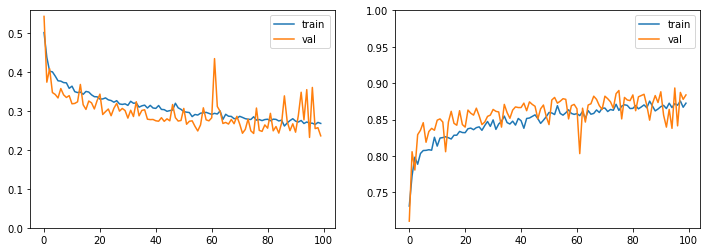

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5948 - accuracy: 0.6998 - precision: 0.8913 - recall: 0.6894 - f1: 0.7715 - specificity: 0.7492 - negative_predictive_value: 0.4332 - matthews_correlation_coefficient: 0.3761 - val_loss: 0.5834 - val_accuracy: 0.7051 - val_precision: 0.8911 - val_recall: 0.6548 - val_f1: 0.7497 - val_specificity: 0.7914 - val_negative_predictive_value: 0.4362 - val_matthews_correlation_coefficient: 0.4073

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40732, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_30-20_37_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5788 - accuracy: 0.7078 - precision: 0.9091 - recall: 0.6826 - f1: 0.7762 - specificity: 0.7853 - negative_predictive_value: 0.4455 - matthews_correlation_coefficient: 0.4051 - val_loss: 0.5329 - val_accuracy: 0.7129 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5618 - accuracy: 0.7067 - precision: 0.9106 - recall: 0.6775 - f1: 0.7730 - specificity: 0.7955 - negative_predictive_value: 0.4465 - matthews_correlation_coefficient: 0.4102 - val_loss: 0.5836 - val_accuracy: 0.7112 - val_precision: 0.8888 - val_recall: 0.6651 - val_f1: 0.7565 - val_specificity: 0.7901 - val_negative_predictive_value: 0.4422 - val_matthews_correlation_coefficient: 0.4130

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.42406
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5605 - accuracy: 0.7089 - precision: 0.9085 - recall: 0.6850 - f1: 0.7771 - specificity: 0.7895 - negative_predictive_value: 0.4493 - matthews_correlation_coefficient: 0.4096 - val_loss: 0.5355 - val_accuracy: 0.7207 - val_precision: 0.8779 - val_recall: 0.6897 - val_f1: 0.7677 - val_specificity: 0.7501 - val_negative_predictive_value: 0.4510 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5528 - accuracy: 0.7134 - precision: 0.9116 - recall: 0.6886 - f1: 0.7813 - specificity: 0.7895 - negative_predictive_value: 0.4503 - matthews_correlation_coefficient: 0.4140 - val_loss: 0.5280 - val_accuracy: 0.7173 - val_precision: 0.8896 - val_recall: 0.6743 - val_f1: 0.7620 - val_specificity: 0.7844 - val_negative_predictive_value: 0.4501 - val_matthews_correlation_coefficient: 0.4196

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42406
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5501 - accuracy: 0.7148 - precision: 0.9065 - recall: 0.6835 - f1: 0.7760 - specificity: 0.8007 - negative_predictive_value: 0.4513 - matthews_correlation_coefficient: 0.4137 - val_loss: 0.5995 - val_accuracy: 0.7008 - val_precision: 0.8938 - val_recall: 0.6467 - val_f1: 0.7454 - val_specificity: 0.7989 - val_negative_predictive_value: 0.4306 - val_matthews_correlation_coefficie

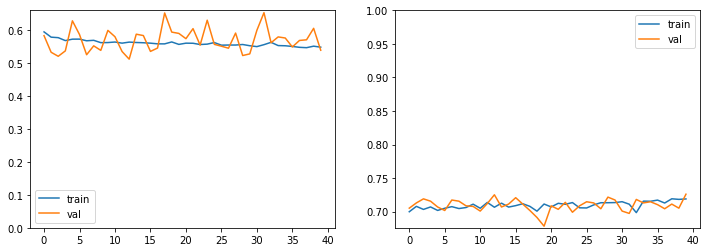

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6120 - accuracy: 0.6605 - precision: 0.6968 - recall: 0.6474 - f1: 0.6335 - specificity: 0.6692 - negative_predictive_value: 0.6701 - matthews_correlation_coefficient: 0.3455 - val_loss: 0.5784 - val_accuracy: 0.7008 - val_precision: 0.7843 - val_recall: 0.6165 - val_f1: 0.6814 - val_specificity: 0.7898 - val_negative_predictive_value: 0.6337 - val_matthews_correlation_coefficient: 0.4118

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.41181, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_30-20_43_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5638 - accuracy: 0.7141 - precision: 0.7256 - recall: 0.7594 - f1: 0.7250 - specificity: 0.6682 - negative_predictive_value: 0.7277 - matthews_correlation_coefficient: 0.4412 - val_loss: 0.5389 - val_accuracy: 0.7407 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4613 - accuracy: 0.7744 - precision: 0.7761 - recall: 0.8042 - f1: 0.7807 - specificity: 0.7394 - negative_predictive_value: 0.7778 - matthews_correlation_coefficient: 0.5499 - val_loss: 0.4652 - val_accuracy: 0.7658 - val_precision: 0.7833 - val_recall: 0.7748 - val_f1: 0.7739 - val_specificity: 0.7414 - val_negative_predictive_value: 0.7309 - val_matthews_correlation_coefficient: 0.5151

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.52292
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4553 - accuracy: 0.7779 - precision: 0.7724 - recall: 0.8069 - f1: 0.7832 - specificity: 0.7409 - negative_predictive_value: 0.7884 - matthews_correlation_coefficient: 0.5556 - val_loss: 0.4600 - val_accuracy: 0.7814 - val_precision: 0.8116 - val_recall: 0.7714 - val_f1: 0.7860 - val_specificity: 0.7770 - val_negative_predictive_value: 0.7349 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4349 - accuracy: 0.7915 - precision: 0.7936 - recall: 0.8200 - f1: 0.7996 - specificity: 0.7592 - negative_predictive_value: 0.7932 - matthews_correlation_coefficient: 0.5844 - val_loss: 0.4340 - val_accuracy: 0.7979 - val_precision: 0.7942 - val_recall: 0.8361 - val_f1: 0.8107 - val_specificity: 0.7352 - val_negative_predictive_value: 0.7853 - val_matthews_correlation_coefficient: 0.5752

Epoch 00028: val_matthews_correlation_coefficient improved from 0.55877 to 0.57522, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_30-20_43_52.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4333 - accuracy: 0.7781 - precision: 0.7793 - recall: 0.8104 - f1: 0.7858 - specificity: 0.7490 - negative_predictive_value: 0.7925 - matthews_correlation_coefficient: 0.5651 - val_loss: 0.4392 - val_accuracy: 0.7788 - val_precision: 0.8315 - val_recall: 0.7387 - val_f1: 0.77

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4150 - accuracy: 0.7950 - precision: 0.8028 - recall: 0.8140 - f1: 0.8028 - specificity: 0.7683 - negative_predictive_value: 0.7869 - matthews_correlation_coefficient: 0.5876 - val_loss: 0.4465 - val_accuracy: 0.7814 - val_precision: 0.7958 - val_recall: 0.7862 - val_f1: 0.7872 - val_specificity: 0.7565 - val_negative_predictive_value: 0.7463 - val_matthews_correlation_coefficient: 0.5422

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.58267
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4213 - accuracy: 0.7950 - precision: 0.7939 - recall: 0.8289 - f1: 0.8033 - specificity: 0.7585 - negative_predictive_value: 0.7987 - matthews_correlation_coefficient: 0.5913 - val_loss: 0.4384 - val_accuracy: 0.7918 - val_precision: 0.7884 - val_recall: 0.8322 - val_f1: 0.8063 - val_specificity: 0.7252 - val_negative_predictive_value: 0.7766 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4021 - accuracy: 0.8030 - precision: 0.8106 - recall: 0.8177 - f1: 0.8052 - specificity: 0.7857 - negative_predictive_value: 0.7992 - matthews_correlation_coefficient: 0.6079 - val_loss: 0.4437 - val_accuracy: 0.8023 - val_precision: 0.8252 - val_recall: 0.7952 - val_f1: 0.8055 - val_specificity: 0.7904 - val_negative_predictive_value: 0.7603 - val_matthews_correlation_coefficient: 0.5853

Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.59199
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4171 - accuracy: 0.7946 - precision: 0.8059 - recall: 0.8132 - f1: 0.8004 - specificity: 0.7828 - negative_predictive_value: 0.7946 - matthews_correlation_coefficient: 0.5975 - val_loss: 0.4178 - val_accuracy: 0.8092 - val_precision: 0.7929 - val_recall: 0.8700 - val_f1: 0.8263 - val_specificity: 0.7243 - val_negative_predictive_value: 0.8111 - val_matthews_correlation_coefficie


Epoch 00070: val_matthews_correlation_coefficient did not improve from 0.60913
Epoch 71/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4075 - accuracy: 0.8067 - precision: 0.8264 - recall: 0.8145 - f1: 0.8099 - specificity: 0.8055 - negative_predictive_value: 0.8063 - matthews_correlation_coefficient: 0.6258 - val_loss: 0.4328 - val_accuracy: 0.7832 - val_precision: 0.8083 - val_recall: 0.7680 - val_f1: 0.7834 - val_specificity: 0.7825 - val_negative_predictive_value: 0.7385 - val_matthews_correlation_coefficient: 0.5484

Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.60913
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3930 - accuracy: 0.8171 - precision: 0.8235 - recall: 0.8286 - f1: 0.8180 - specificity: 0.7979 - negative_predictive_value: 0.8121 - matthews_correlation_coefficient: 0.6324 - val_loss: 0.4372 - val_accuracy: 0.7944 - val_precision: 0.7566 - val_recall: 0.9086 - val_f1: 0.8227 - val_spe


Epoch 00085: val_matthews_correlation_coefficient did not improve from 0.60913
Epoch 86/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3879 - accuracy: 0.8137 - precision: 0.8114 - recall: 0.8306 - f1: 0.8143 - specificity: 0.7943 - negative_predictive_value: 0.8187 - matthews_correlation_coefficient: 0.6271 - val_loss: 0.4585 - val_accuracy: 0.7988 - val_precision: 0.8082 - val_recall: 0.8169 - val_f1: 0.8082 - val_specificity: 0.7602 - val_negative_predictive_value: 0.7689 - val_matthews_correlation_coefficient: 0.5770

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.60913
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3820 - accuracy: 0.8148 - precision: 0.8271 - recall: 0.8295 - f1: 0.8207 - specificity: 0.8036 - negative_predictive_value: 0.8135 - matthews_correlation_coefficient: 0.6365 - val_loss: 0.4740 - val_accuracy: 0.7944 - val_precision: 0.7682 - val_recall: 0.8809 - val_f1: 0.8174 - val_spe

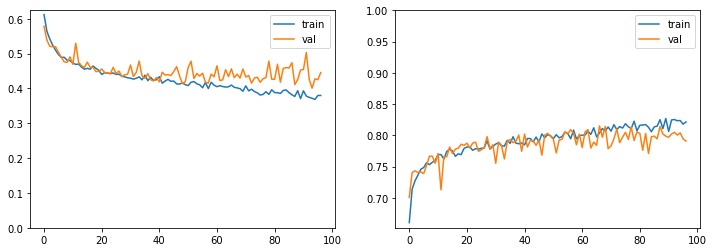

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6493 - accuracy: 0.5228 - precision: 0.8932 - recall: 0.4537 - f1: 0.5898 - specificity: 0.7909 - negative_predictive_value: 0.2825 - matthews_correlation_coefficient: 0.2063 - val_loss: 0.6377 - val_accuracy: 0.5525 - val_precision: 0.9425 - val_recall: 0.4777 - val_f1: 0.6233 - val_specificity: 0.8526 - val_negative_predictive_value: 0.3022 - val_matthews_correlation_coefficient: 0.2825

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28249, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_30-20_58_16.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6297 - accuracy: 0.5443 - precision: 0.9140 - recall: 0.4694 - f1: 0.6073 - specificity: 0.8121 - negative_predictive_value: 0.2945 - matthews_correlation_coefficient: 0.2417 - val_loss: 0.6451 - val_accuracy: 0.5308 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36651
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5746 - accuracy: 0.6562 - precision: 0.9073 - recall: 0.6213 - f1: 0.7277 - specificity: 0.7675 - negative_predictive_value: 0.3654 - matthews_correlation_coefficient: 0.3302 - val_loss: 0.5997 - val_accuracy: 0.6245 - val_precision: 0.9246 - val_recall: 0.5847 - val_f1: 0.7101 - val_specificity: 0.7867 - val_negative_predictive_value: 0.3284 - val_matthews_correlation_coefficient: 0.3051

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36651
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5721 - accuracy: 0.6733 - precision: 0.9002 - recall: 0.6603 - f1: 0.7517 - specificity: 0.7250 - negative_predictive_value: 0.3792 - matthews_correlation_coefficient: 0.3252 - val_loss: 0.5757 - val_accuracy: 0.6418 - val_precision: 0.9204 - val_recall: 0.6097 - val_f1: 0.7281 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37288
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5340 - accuracy: 0.7004 - precision: 0.9125 - recall: 0.6755 - f1: 0.7703 - specificity: 0.7825 - negative_predictive_value: 0.4079 - matthews_correlation_coefficient: 0.3809 - val_loss: 0.5934 - val_accuracy: 0.6592 - val_precision: 0.9425 - val_recall: 0.6158 - val_f1: 0.7393 - val_specificity: 0.8325 - val_negative_predictive_value: 0.3609 - val_matthews_correlation_coefficient: 0.3673

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37288
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5541 - accuracy: 0.6831 - precision: 0.9100 - recall: 0.6575 - f1: 0.7538 - specificity: 0.7619 - negative_predictive_value: 0.3961 - matthews_correlation_coefficient: 0.3614 - val_loss: 0.5174 - val_accuracy: 0.7355 - val_precision: 0.9122 - val_recall: 0.7418 - val_f1: 0.8150 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5223 - accuracy: 0.7093 - precision: 0.9184 - recall: 0.6946 - f1: 0.7855 - specificity: 0.7765 - negative_predictive_value: 0.4181 - matthews_correlation_coefficient: 0.3954 - val_loss: 0.5555 - val_accuracy: 0.7095 - val_precision: 0.9242 - val_recall: 0.6959 - val_f1: 0.7893 - val_specificity: 0.7609 - val_negative_predictive_value: 0.4001 - val_matthews_correlation_coefficient: 0.3836

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39411
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5243 - accuracy: 0.7104 - precision: 0.9159 - recall: 0.7023 - f1: 0.7885 - specificity: 0.7478 - negative_predictive_value: 0.4083 - matthews_correlation_coefficient: 0.3784 - val_loss: 0.5142 - val_accuracy: 0.7199 - val_precision: 0.9044 - val_recall: 0.7289 - val_f1: 0.8045 - val_specificity: 0.6858 - val_negative_predictive_value: 0.4006 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4989 - accuracy: 0.7289 - precision: 0.9183 - recall: 0.7117 - f1: 0.7965 - specificity: 0.7778 - negative_predictive_value: 0.4338 - matthews_correlation_coefficient: 0.4142 - val_loss: 0.5981 - val_accuracy: 0.6626 - val_precision: 0.9298 - val_recall: 0.6274 - val_f1: 0.7439 - val_specificity: 0.8070 - val_negative_predictive_value: 0.3646 - val_matthews_correlation_coefficient: 0.3562

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5075 - accuracy: 0.7252 - precision: 0.9192 - recall: 0.7164 - f1: 0.7972 - specificity: 0.7695 - negative_predictive_value: 0.4280 - matthews_correlation_coefficient: 0.4085 - val_loss: 0.7665 - val_accuracy: 0.5429 - val_precision: 0.9443 - val_recall: 0.4611 - val_f1: 0.6116 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5054 - accuracy: 0.7310 - precision: 0.9253 - recall: 0.7169 - f1: 0.8019 - specificity: 0.7777 - negative_predictive_value: 0.4369 - matthews_correlation_coefficient: 0.4213 - val_loss: 0.5618 - val_accuracy: 0.6843 - val_precision: 0.9274 - val_recall: 0.6603 - val_f1: 0.7676 - val_specificity: 0.7862 - val_negative_predictive_value: 0.3768 - val_matthews_correlation_coefficient: 0.3671

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4871 - accuracy: 0.7345 - precision: 0.9278 - recall: 0.7240 - f1: 0.8072 - specificity: 0.7877 - negative_predictive_value: 0.4470 - matthews_correlation_coefficient: 0.4333 - val_loss: 0.6183 - val_accuracy: 0.6453 - val_precision: 0.9276 - val_recall: 0.6077 - val_f1: 0.7304 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41839
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4849 - accuracy: 0.7421 - precision: 0.9187 - recall: 0.7274 - f1: 0.8050 - specificity: 0.7666 - negative_predictive_value: 0.4493 - matthews_correlation_coefficient: 0.4223 - val_loss: 0.5580 - val_accuracy: 0.6947 - val_precision: 0.9279 - val_recall: 0.6757 - val_f1: 0.7776 - val_specificity: 0.7776 - val_negative_predictive_value: 0.3860 - val_matthews_correlation_coefficient: 0.3756

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41839
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4976 - accuracy: 0.7206 - precision: 0.9225 - recall: 0.6947 - f1: 0.7837 - specificity: 0.8040 - negative_predictive_value: 0.4317 - matthews_correlation_coefficient: 0.4225 - val_loss: 0.6878 - val_accuracy: 0.6132 - val_precision: 0.9424 - val_recall: 0.5522 - val_f1: 0.6904 - val_spe

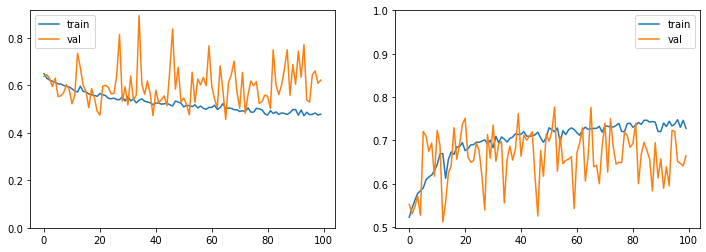

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4511 - accuracy: 0.7701 - precision: 0.8654 - recall: 0.7551 - f1: 0.7996 - specificity: 0.7950 - negative_predictive_value: 0.6524 - matthews_correlation_coefficient: 0.5396 - val_loss: 0.4427 - val_accuracy: 0.7650 - val_precision: 0.8709 - val_recall: 0.6866 - val_f1: 0.7623 - val_specificity: 0.8615 - val_negative_predictive_value: 0.6438 - val_matthews_correlation_coefficient: 0.5299

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.52990, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_30-21_13_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4141 - accuracy: 0.7874 - precision: 0.9060 - recall: 0.7516 - f1: 0.8140 - specificity: 0.8648 - negative_predictive_value: 0.6706 - matthews_correlation_coefficient: 0.5948 - val_loss: 0.4059 - val_accuracy: 0.7927 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3480 - accuracy: 0.8341 - precision: 0.9197 - recall: 0.8120 - f1: 0.8586 - specificity: 0.8827 - negative_predictive_value: 0.7317 - matthews_correlation_coefficient: 0.6720 - val_loss: 0.4055 - val_accuracy: 0.7979 - val_precision: 0.9289 - val_recall: 0.6937 - val_f1: 0.7881 - val_specificity: 0.9425 - val_negative_predictive_value: 0.6683 - val_matthews_correlation_coefficient: 0.6146

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.64928
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3464 - accuracy: 0.8354 - precision: 0.9233 - recall: 0.8138 - f1: 0.8596 - specificity: 0.8852 - negative_predictive_value: 0.7398 - matthews_correlation_coefficient: 0.6799 - val_loss: 0.4067 - val_accuracy: 0.7875 - val_precision: 0.9287 - val_recall: 0.6807 - val_f1: 0.7771 - val_specificity: 0.9395 - val_negative_predictive_value: 0.6579 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3117 - accuracy: 0.8625 - precision: 0.9288 - recall: 0.8516 - f1: 0.8850 - specificity: 0.8831 - negative_predictive_value: 0.7715 - matthews_correlation_coefficient: 0.7166 - val_loss: 0.3203 - val_accuracy: 0.8604 - val_precision: 0.8391 - val_recall: 0.9030 - val_f1: 0.8675 - val_specificity: 0.7569 - val_negative_predictive_value: 0.8583 - val_matthews_correlation_coefficient: 0.6777

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.71293
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3099 - accuracy: 0.8603 - precision: 0.9245 - recall: 0.8493 - f1: 0.8810 - specificity: 0.8739 - negative_predictive_value: 0.7723 - matthews_correlation_coefficient: 0.7107 - val_loss: 0.3468 - val_accuracy: 0.8387 - val_precision: 0.8225 - val_recall: 0.8909 - val_f1: 0.8519 - val_specificity: 0.7191 - val_negative_predictive_value: 0.8349 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient improved from 0.71914 to 0.72368, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_30-21_13_14.h5
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2872 - accuracy: 0.8781 - precision: 0.9283 - recall: 0.8748 - f1: 0.8968 - specificity: 0.8826 - negative_predictive_value: 0.7983 - matthews_correlation_coefficient: 0.7427 - val_loss: 0.3203 - val_accuracy: 0.8586 - val_precision: 0.9296 - val_recall: 0.7920 - val_f1: 0.8513 - val_specificity: 0.9383 - val_negative_predictive_value: 0.7560 - val_matthews_correlation_coefficient: 0.7069

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72368
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2941 - accuracy: 0.8698 - precision: 0.9259 - recall: 0.8547 - f1: 0.8859 - specificity: 0.8869 - negative_predictive_value: 0.7789 - matthews_correlation_coefficient: 0.7290 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2780 - accuracy: 0.8787 - precision: 0.9352 - recall: 0.8710 - f1: 0.8993 - specificity: 0.8872 - negative_predictive_value: 0.7937 - matthews_correlation_coefficient: 0.7428 - val_loss: 0.3063 - val_accuracy: 0.8647 - val_precision: 0.9257 - val_recall: 0.8089 - val_f1: 0.8598 - val_specificity: 0.9249 - val_negative_predictive_value: 0.7655 - val_matthews_correlation_coefficient: 0.7113

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.73946
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2697 - accuracy: 0.8829 - precision: 0.9325 - recall: 0.8762 - f1: 0.8996 - specificity: 0.8943 - negative_predictive_value: 0.8053 - matthews_correlation_coefficient: 0.7552 - val_loss: 0.2897 - val_accuracy: 0.8812 - val_precision: 0.8703 - val_recall: 0.8946 - val_f1: 0.8803 - val_specificity: 0.8195 - val_negative_predictive_value: 0.8585 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.77343
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2521 - accuracy: 0.8896 - precision: 0.9356 - recall: 0.8866 - f1: 0.9082 - specificity: 0.8983 - negative_predictive_value: 0.8206 - matthews_correlation_coefficient: 0.7699 - val_loss: 0.3425 - val_accuracy: 0.8343 - val_precision: 0.9324 - val_recall: 0.7540 - val_f1: 0.8288 - val_specificity: 0.9425 - val_negative_predictive_value: 0.7164 - val_matthews_correlation_coefficient: 0.6712

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.77343
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2569 - accuracy: 0.8892 - precision: 0.9350 - recall: 0.8876 - f1: 0.9076 - specificity: 0.8952 - negative_predictive_value: 0.8194 - matthews_correlation_coefficient: 0.7675 - val_loss: 0.3104 - val_accuracy: 0.8656 - val_precision: 0.9028 - val_recall: 0.8318 - val_f1: 0.8623 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.78396
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2432 - accuracy: 0.8998 - precision: 0.9434 - recall: 0.8990 - f1: 0.9181 - specificity: 0.9003 - negative_predictive_value: 0.8318 - matthews_correlation_coefficient: 0.7864 - val_loss: 0.2696 - val_accuracy: 0.8977 - val_precision: 0.9140 - val_recall: 0.8736 - val_f1: 0.8901 - val_specificity: 0.9027 - val_negative_predictive_value: 0.8451 - val_matthews_correlation_coefficient: 0.7670

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.78396
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2475 - accuracy: 0.8918 - precision: 0.9353 - recall: 0.8942 - f1: 0.9114 - specificity: 0.8930 - negative_predictive_value: 0.8286 - matthews_correlation_coefficient: 0.7746 - val_loss: 0.2802 - val_accuracy: 0.8925 - val_precision: 0.8946 - val_recall: 0.8861 - val_f1: 0.8875 - val_spe

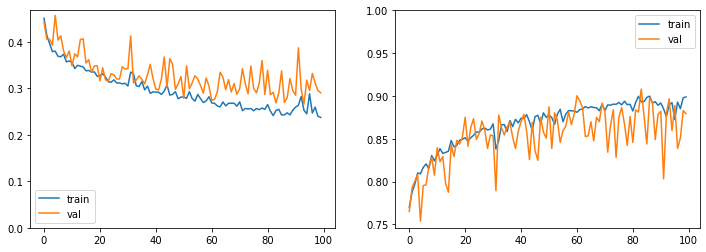

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5879 - accuracy: 0.6787 - precision: 0.7801 - recall: 0.6755 - f1: 0.7096 - specificity: 0.6817 - negative_predictive_value: 0.5800 - matthews_correlation_coefficient: 0.3595 - val_loss: 0.5282 - val_accuracy: 0.7598 - val_precision: 0.7290 - val_recall: 0.8907 - val_f1: 0.7999 - val_specificity: 0.4880 - val_negative_predictive_value: 0.7606 - val_matthews_correlation_coefficient: 0.4552

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.45519, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_30-21_28_31.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5586 - accuracy: 0.7082 - precision: 0.8093 - recall: 0.7042 - f1: 0.7396 - specificity: 0.7160 - negative_predictive_value: 0.6140 - matthews_correlation_coefficient: 0.4201 - val_loss: 0.5073 - val_accuracy: 0.7641 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.54679
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4771 - accuracy: 0.7777 - precision: 0.8461 - recall: 0.7905 - f1: 0.8113 - specificity: 0.7625 - negative_predictive_value: 0.6973 - matthews_correlation_coefficient: 0.5473 - val_loss: 0.4557 - val_accuracy: 0.7979 - val_precision: 0.8287 - val_recall: 0.7885 - val_f1: 0.8065 - val_specificity: 0.7743 - val_negative_predictive_value: 0.7239 - val_matthews_correlation_coefficient: 0.5572

Epoch 00015: val_matthews_correlation_coefficient improved from 0.54679 to 0.55720, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_30-21_28_31.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4733 - accuracy: 0.7794 - precision: 0.8423 - recall: 0.7925 - f1: 0.8110 - specificity: 0.7640 - negative_predictive_value: 0.7028 - matthews_correlation_coefficient: 0.5500 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4398 - accuracy: 0.8046 - precision: 0.8653 - recall: 0.8152 - f1: 0.8347 - specificity: 0.7949 - negative_predictive_value: 0.7299 - matthews_correlation_coefficient: 0.6019 - val_loss: 0.4331 - val_accuracy: 0.8023 - val_precision: 0.7927 - val_recall: 0.8582 - val_f1: 0.8215 - val_specificity: 0.6562 - val_negative_predictive_value: 0.7579 - val_matthews_correlation_coefficient: 0.5583

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.59846
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4324 - accuracy: 0.8106 - precision: 0.8621 - recall: 0.8223 - f1: 0.8365 - specificity: 0.7925 - negative_predictive_value: 0.7357 - matthews_correlation_coefficient: 0.6074 - val_loss: 0.4155 - val_accuracy: 0.8326 - val_precision: 0.8004 - val_recall: 0.9067 - val_f1: 0.8483 - val_specificity: 0.6555 - val_negative_predictive_value: 0.8350 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.62356
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4326 - accuracy: 0.8069 - precision: 0.8651 - recall: 0.8225 - f1: 0.8376 - specificity: 0.7936 - negative_predictive_value: 0.7362 - matthews_correlation_coefficient: 0.6080 - val_loss: 0.4085 - val_accuracy: 0.8283 - val_precision: 0.8043 - val_recall: 0.8915 - val_f1: 0.8435 - val_specificity: 0.6728 - val_negative_predictive_value: 0.8087 - val_matthews_correlation_coefficient: 0.6145

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.62356
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4274 - accuracy: 0.8169 - precision: 0.8728 - recall: 0.8293 - f1: 0.8441 - specificity: 0.8020 - negative_predictive_value: 0.7502 - matthews_correlation_coefficient: 0.6264 - val_loss: 0.4515 - val_accuracy: 0.8153 - val_precision: 0.8674 - val_recall: 0.7735 - val_f1: 0.8160 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.62927
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4077 - accuracy: 0.8191 - precision: 0.8760 - recall: 0.8284 - f1: 0.8467 - specificity: 0.8104 - negative_predictive_value: 0.7487 - matthews_correlation_coefficient: 0.6307 - val_loss: 0.4121 - val_accuracy: 0.8196 - val_precision: 0.8418 - val_recall: 0.8137 - val_f1: 0.8258 - val_specificity: 0.7963 - val_negative_predictive_value: 0.7527 - val_matthews_correlation_coefficient: 0.6019

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.62927
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4021 - accuracy: 0.8284 - precision: 0.8799 - recall: 0.8375 - f1: 0.8540 - specificity: 0.8071 - negative_predictive_value: 0.7549 - matthews_correlation_coefficient: 0.6407 - val_loss: 0.3951 - val_accuracy: 0.8352 - val_precision: 0.8169 - val_recall: 0.8859 - val_f1: 0.8478 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4094 - accuracy: 0.8184 - precision: 0.8650 - recall: 0.8286 - f1: 0.8401 - specificity: 0.8026 - negative_predictive_value: 0.7527 - matthews_correlation_coefficient: 0.6252 - val_loss: 0.4162 - val_accuracy: 0.8404 - val_precision: 0.8589 - val_recall: 0.8320 - val_f1: 0.8435 - val_specificity: 0.8189 - val_negative_predictive_value: 0.7799 - val_matthews_correlation_coefficient: 0.6446

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.64598
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3923 - accuracy: 0.8312 - precision: 0.8779 - recall: 0.8451 - f1: 0.8571 - specificity: 0.8132 - negative_predictive_value: 0.7684 - matthews_correlation_coefficient: 0.6514 - val_loss: 0.4371 - val_accuracy: 0.8161 - val_precision: 0.8408 - val_recall: 0.8135 - val_f1: 0.8237 - val_specificity: 0.7889 - val_negative_predictive_value: 0.7528 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.66413
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3875 - accuracy: 0.8354 - precision: 0.8767 - recall: 0.8402 - f1: 0.8545 - specificity: 0.8219 - negative_predictive_value: 0.7712 - matthews_correlation_coefficient: 0.6561 - val_loss: 0.4530 - val_accuracy: 0.7962 - val_precision: 0.8733 - val_recall: 0.7367 - val_f1: 0.7963 - val_specificity: 0.8631 - val_negative_predictive_value: 0.6913 - val_matthews_correlation_coefficient: 0.5814

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.66413
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3916 - accuracy: 0.8249 - precision: 0.8729 - recall: 0.8372 - f1: 0.8501 - specificity: 0.8046 - negative_predictive_value: 0.7504 - matthews_correlation_coefficient: 0.6336 - val_loss: 0.4107 - val_accuracy: 0.8300 - val_precision: 0.8525 - val_recall: 0.8240 - val_f1: 0.8352 - val_spe

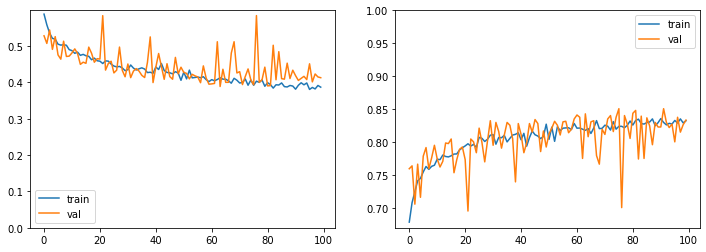

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5830 - accuracy: 0.5458 - precision: 0.9671 - recall: 0.5119 - f1: 0.6608 - specificity: 0.8452 - negative_predictive_value: 0.1871 - matthews_correlation_coefficient: 0.2306 - val_loss: 0.7048 - val_accuracy: 0.4449 - val_precision: 0.9574 - val_recall: 0.3691 - val_f1: 0.5279 - val_specificity: 0.9379 - val_negative_predictive_value: 0.1836 - val_matthews_correlation_coefficient: 0.2068

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20684, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_30-21_43_22.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5708 - accuracy: 0.5312 - precision: 0.9668 - recall: 0.4917 - f1: 0.6395 - specificity: 0.8195 - negative_predictive_value: 0.1817 - matthews_correlation_coefficient: 0.2116 - val_loss: 0.5429 - val_accuracy: 0.5776 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37307
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4672 - accuracy: 0.7306 - precision: 0.9732 - recall: 0.7179 - f1: 0.8181 - specificity: 0.8248 - negative_predictive_value: 0.2924 - matthews_correlation_coefficient: 0.3706 - val_loss: 0.7291 - val_accuracy: 0.5846 - val_precision: 0.9558 - val_recall: 0.5270 - val_f1: 0.6753 - val_specificity: 0.8672 - val_negative_predictive_value: 0.1990 - val_matthews_correlation_coefficient: 0.2740

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37307
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4553 - accuracy: 0.7336 - precision: 0.9715 - recall: 0.7249 - f1: 0.8242 - specificity: 0.8140 - negative_predictive_value: 0.2902 - matthews_correlation_coefficient: 0.3648 - val_loss: 0.3526 - val_accuracy: 0.8361 - val_precision: 0.9299 - val_recall: 0.8337 - val_f1: 0.8778 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7655 - precision: 0.9786 - recall: 0.7549 - f1: 0.8446 - specificity: 0.8480 - negative_predictive_value: 0.3336 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.3705 - val_accuracy: 0.8023 - val_precision: 0.9502 - val_recall: 0.7765 - val_f1: 0.8521 - val_specificity: 0.7862 - val_negative_predictive_value: 0.3368 - val_matthews_correlation_coefficient: 0.4218

Epoch 00029: val_matthews_correlation_coefficient improved from 0.40947 to 0.42182, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_30-21_43_22.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7397 - precision: 0.9751 - recall: 0.7300 - f1: 0.8247 - specificity: 0.8286 - negative_predictive_value: 0.3063 - matthews_correlation_coefficient: 0.3868 - val_loss: 0.7702 - val_accuracy: 0.5663 - val_precision: 0.9658 - val_recall: 0.5010 - val_f1: 0.6543 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3606 - accuracy: 0.7941 - precision: 0.9807 - recall: 0.7828 - f1: 0.8668 - specificity: 0.8456 - negative_predictive_value: 0.3503 - matthews_correlation_coefficient: 0.4505 - val_loss: 0.5134 - val_accuracy: 0.7164 - val_precision: 0.9634 - val_recall: 0.6689 - val_f1: 0.7868 - val_specificity: 0.9274 - val_negative_predictive_value: 0.2930 - val_matthews_correlation_coefficient: 0.3827

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45192
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3851 - accuracy: 0.7790 - precision: 0.9786 - recall: 0.7689 - f1: 0.8550 - specificity: 0.8388 - negative_predictive_value: 0.3393 - matthews_correlation_coefficient: 0.4316 - val_loss: 0.5628 - val_accuracy: 0.6817 - val_precision: 0.9646 - val_recall: 0.6292 - val_f1: 0.7578 - val_specificity: 0.9315 - val_negative_predictive_value: 0.2707 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3494 - accuracy: 0.8011 - precision: 0.9820 - recall: 0.7937 - f1: 0.8736 - specificity: 0.8469 - negative_predictive_value: 0.3720 - matthews_correlation_coefficient: 0.4698 - val_loss: 0.5533 - val_accuracy: 0.7008 - val_precision: 0.9650 - val_recall: 0.6508 - val_f1: 0.7734 - val_specificity: 0.9290 - val_negative_predictive_value: 0.2866 - val_matthews_correlation_coefficient: 0.3738

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45192
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3641 - accuracy: 0.8020 - precision: 0.9805 - recall: 0.7916 - f1: 0.8703 - specificity: 0.8549 - negative_predictive_value: 0.3820 - matthews_correlation_coefficient: 0.4728 - val_loss: 0.5562 - val_accuracy: 0.7016 - val_precision: 0.9663 - val_recall: 0.6504 - val_f1: 0.7736 - val_specificity: 0.9396 - val_negative_predictive_value: 0.2878 - val_matthews_correlation_coefficie

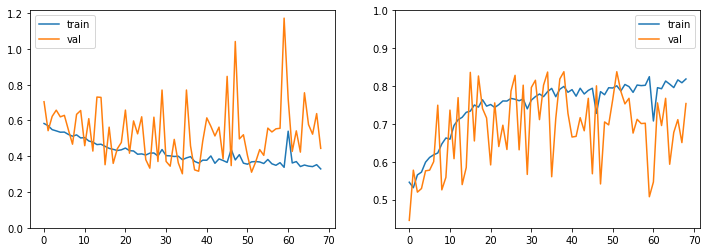

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5847 - accuracy: 0.6562 - precision: 0.9059 - recall: 0.6356 - f1: 0.7393 - specificity: 0.7382 - negative_predictive_value: 0.3557 - matthews_correlation_coefficient: 0.3111 - val_loss: 0.6570 - val_accuracy: 0.6262 - val_precision: 0.9083 - val_recall: 0.5987 - val_f1: 0.7150 - val_specificity: 0.7442 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.2851

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28514, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_30-21_53_44.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5654 - accuracy: 0.6915 - precision: 0.9001 - recall: 0.6882 - f1: 0.7745 - specificity: 0.7060 - negative_predictive_value: 0.3810 - matthews_correlation_coefficient: 0.3313 - val_loss: 0.6147 - val_accuracy: 0.6279 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5411 - accuracy: 0.6560 - precision: 0.9225 - recall: 0.6238 - f1: 0.7308 - specificity: 0.7958 - negative_predictive_value: 0.3720 - matthews_correlation_coefficient: 0.3464 - val_loss: 0.6817 - val_accuracy: 0.6088 - val_precision: 0.9409 - val_recall: 0.5537 - val_f1: 0.6884 - val_specificity: 0.8383 - val_negative_predictive_value: 0.3261 - val_matthews_correlation_coefficient: 0.3217

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34989
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5318 - accuracy: 0.6941 - precision: 0.9181 - recall: 0.6782 - f1: 0.7732 - specificity: 0.7623 - negative_predictive_value: 0.3902 - matthews_correlation_coefficient: 0.3666 - val_loss: 0.6598 - val_accuracy: 0.6279 - val_precision: 0.9405 - val_recall: 0.5795 - val_f1: 0.7081 - val_specificity: 0.8295 - val_negative_predictive_value: 0.3384 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.38700
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5018 - accuracy: 0.7200 - precision: 0.9231 - recall: 0.7090 - f1: 0.7946 - specificity: 0.7615 - negative_predictive_value: 0.4158 - matthews_correlation_coefficient: 0.3979 - val_loss: 0.5169 - val_accuracy: 0.7164 - val_precision: 0.9160 - val_recall: 0.7172 - val_f1: 0.8009 - val_specificity: 0.7321 - val_negative_predictive_value: 0.3962 - val_matthews_correlation_coefficient: 0.3728

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38700
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4948 - accuracy: 0.7215 - precision: 0.9197 - recall: 0.7024 - f1: 0.7908 - specificity: 0.7760 - negative_predictive_value: 0.4134 - matthews_correlation_coefficient: 0.4018 - val_loss: 0.5182 - val_accuracy: 0.7121 - val_precision: 0.9231 - val_recall: 0.7055 - val_f1: 0.7963 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39367
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4857 - accuracy: 0.7252 - precision: 0.9280 - recall: 0.7130 - f1: 0.7986 - specificity: 0.7753 - negative_predictive_value: 0.4338 - matthews_correlation_coefficient: 0.4174 - val_loss: 0.5177 - val_accuracy: 0.7207 - val_precision: 0.9200 - val_recall: 0.7188 - val_f1: 0.8039 - val_specificity: 0.7372 - val_negative_predictive_value: 0.3955 - val_matthews_correlation_coefficient: 0.3779

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39367
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4762 - accuracy: 0.7412 - precision: 0.9264 - recall: 0.7325 - f1: 0.8114 - specificity: 0.7614 - negative_predictive_value: 0.4454 - matthews_correlation_coefficient: 0.4253 - val_loss: 0.8020 - val_accuracy: 0.6227 - val_precision: 0.9474 - val_recall: 0.5681 - val_f1: 0.7028 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39757
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4586 - accuracy: 0.7488 - precision: 0.9233 - recall: 0.7349 - f1: 0.8142 - specificity: 0.7843 - negative_predictive_value: 0.4445 - matthews_correlation_coefficient: 0.4331 - val_loss: 0.5265 - val_accuracy: 0.6886 - val_precision: 0.9273 - val_recall: 0.6694 - val_f1: 0.7734 - val_specificity: 0.7746 - val_negative_predictive_value: 0.3749 - val_matthews_correlation_coefficient: 0.3646

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39757
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4615 - accuracy: 0.7447 - precision: 0.9243 - recall: 0.7282 - f1: 0.8094 - specificity: 0.7850 - negative_predictive_value: 0.4467 - matthews_correlation_coefficient: 0.4343 - val_loss: 0.7401 - val_accuracy: 0.5854 - val_precision: 0.9646 - val_recall: 0.5097 - val_f1: 0.6590 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39929
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4538 - accuracy: 0.7536 - precision: 0.9375 - recall: 0.7409 - f1: 0.8212 - specificity: 0.7982 - negative_predictive_value: 0.4640 - matthews_correlation_coefficient: 0.4629 - val_loss: 0.5854 - val_accuracy: 0.6479 - val_precision: 0.9336 - val_recall: 0.6106 - val_f1: 0.7332 - val_specificity: 0.8035 - val_negative_predictive_value: 0.3445 - val_matthews_correlation_coefficient: 0.3379

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.39929
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4501 - accuracy: 0.7564 - precision: 0.9366 - recall: 0.7463 - f1: 0.8256 - specificity: 0.8013 - negative_predictive_value: 0.4670 - matthews_correlation_coefficient: 0.4651 - val_loss: 0.6364 - val_accuracy: 0.6531 - val_precision: 0.9532 - val_recall: 0.6046 - val_f1: 0.7340 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.40828
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4316 - accuracy: 0.7662 - precision: 0.9364 - recall: 0.7560 - f1: 0.8313 - specificity: 0.8137 - negative_predictive_value: 0.4713 - matthews_correlation_coefficient: 0.4798 - val_loss: 0.5030 - val_accuracy: 0.7207 - val_precision: 0.9246 - val_recall: 0.7176 - val_f1: 0.8043 - val_specificity: 0.7422 - val_negative_predictive_value: 0.3998 - val_matthews_correlation_coefficient: 0.3844

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.40828
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4505 - accuracy: 0.7610 - precision: 0.9322 - recall: 0.7446 - f1: 0.8221 - specificity: 0.8175 - negative_predictive_value: 0.4764 - matthews_correlation_coefficient: 0.4730 - val_loss: 0.5790 - val_accuracy: 0.6652 - val_precision: 0.9363 - val_recall: 0.6325 - val_f1: 0.7500 - val_spe

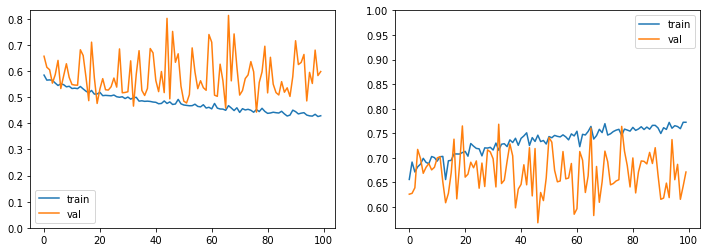

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_30-22_08_43.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.9013 - precision: 1.0000 - recall: 0.9017 - f1: 0.9469 - specificity: 0.0966 - negative_predictive_value: 0.0336 - matthews_correlation_coefficient: 0.0542 - val_loss: 0.1913 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9187 - val_f1: 0.9568 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficient: 0.0655

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1305 - accuracy: 0.9252 - precision: 1.0000 - recall: 0.9254 - f1: 0.9606 - specificity: 0.0966 - negative_predictive_value: 0.0402 - matthews_correlation_coefficient: 0.0575 - val_loss: 0.0624 - val_accuracy: 0.9696 - val_precision: 1.0000 - val_recall: 0.9704 - val_f1: 0.9847 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_30-22_08_43.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1054 - accuracy: 0.9408 - precision: 1.0000 - recall: 0.9410 - f1: 0.9689 - specificity: 0.1034 - negative_predictive_value: 0.0632 - matthews_correlation_coefficient: 0.0761 - val_loss: 0.0632 - val_accuracy: 0.9731 - val_precision: 1.0000 - val_recall: 0.9738 - val_f1: 0.9865 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0870 - accuracy: 0.9566 - precision: 1.0000 - recall: 0.9568 - f1: 0.9774 - specificity: 0.0966 - negative_predictive_value: 0.0592 - matthews_correlation_coefficient: 0.0721 - val_loss: 0.14


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1048 - accuracy: 0.9453 - precision: 1.0000 - recall: 0.9455 - f1: 0.9715 - specificity: 0.1034 - negative_predictive_value: 0.0474 - matthews_correlation_coefficient: 0.0674 - val_loss: 0.0980 - val_accuracy: 0.9627 - val_precision: 1.0000 - val_recall: 0.9636 - val_f1: 0.9811 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0901 - val_matthews_correlation_coefficient: 0.0962

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0549 - accuracy: 0.9672 - precision: 1.0000 - recall: 0.9674 - f1: 0.9832 - specificity: 0.1034 - negative_predictive_value: 0.0730 - matthews_correlation_coefficient: 0.0842 - val_loss: 0.0567 - val_accuracy: 0.9783 - val_precision: 1.0000 - val_recall: 0.9789 - val_f1: 0.9891 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.35%
  Final Precision: 100.00%
     Final Recall:  98.35%
  Final F-measure:  99.17%
Final Specificity: 100.00%
        Final NPV:  17.39%
        Final MCC:  41.36%
[[   4    0]
 [  19 1130]]
              precision    recall  f1-score   support

           0       0.17      1.00      0.30         4
           1       1.00      0.98      0.99      1149

    accuracy                           0.98      1153
   macro avg       0.59      0.99      0.64      1153
weighted avg       1.00      0.98      0.99      1153



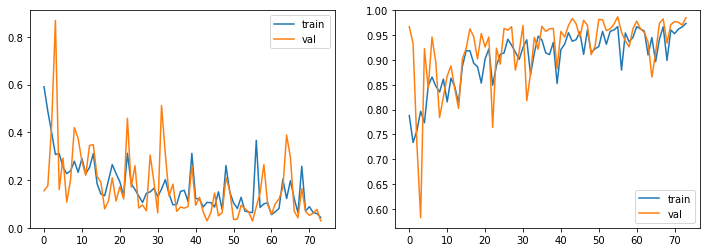

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6024 - accuracy: 0.6280 - precision: 0.8711 - recall: 0.5551 - f1: 0.6662 - specificity: 0.7989 - negative_predictive_value: 0.4296 - matthews_correlation_coefficient: 0.3240 - val_loss: 0.6589 - val_accuracy: 0.5499 - val_precision: 0.8899 - val_recall: 0.3902 - val_f1: 0.5348 - val_specificity: 0.8892 - val_negative_predictive_value: 0.3752 - val_matthews_correlation_coefficient: 0.2967

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29665, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_30-22_19_54.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5935 - accuracy: 0.6239 - precision: 0.8881 - recall: 0.5536 - f1: 0.6673 - specificity: 0.8030 - negative_predictive_value: 0.4235 - matthews_correlation_coefficient: 0.3314 - val_loss: 0.5311 - val_accuracy: 0.6956 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5437 - accuracy: 0.6896 - precision: 0.9016 - recall: 0.6288 - f1: 0.7338 - specificity: 0.8341 - negative_predictive_value: 0.4797 - matthews_correlation_coefficient: 0.4182 - val_loss: 0.6229 - val_accuracy: 0.6574 - val_precision: 0.9030 - val_recall: 0.5439 - val_f1: 0.6724 - val_specificity: 0.8638 - val_negative_predictive_value: 0.4406 - val_matthews_correlation_coefficient: 0.3992

Epoch 00015: val_matthews_correlation_coefficient improved from 0.38493 to 0.39915, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_30-22_19_54.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5482 - accuracy: 0.6831 - precision: 0.8930 - recall: 0.6240 - f1: 0.7277 - specificity: 0.8226 - negative_predictive_value: 0.4745 - matthews_correlation_coefficient: 0.4099 - val_loss: 0.5591 - val_accuracy: 0.6973 - val_precision: 0.8830 - val_recall: 0.6185 - val_f1: 0.7222 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5159 - accuracy: 0.7113 - precision: 0.9174 - recall: 0.6560 - f1: 0.7577 - specificity: 0.8478 - negative_predictive_value: 0.4994 - matthews_correlation_coefficient: 0.4559 - val_loss: 0.4913 - val_accuracy: 0.7268 - val_precision: 0.8323 - val_recall: 0.7135 - val_f1: 0.7647 - val_specificity: 0.6932 - val_negative_predictive_value: 0.5145 - val_matthews_correlation_coefficient: 0.4009

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42235
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5068 - accuracy: 0.7178 - precision: 0.9191 - recall: 0.6642 - f1: 0.7653 - specificity: 0.8507 - negative_predictive_value: 0.5084 - matthews_correlation_coefficient: 0.4688 - val_loss: 0.5382 - val_accuracy: 0.6921 - val_precision: 0.8683 - val_recall: 0.6259 - val_f1: 0.7210 - val_specificity: 0.7905 - val_negative_predictive_value: 0.4719 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5016 - accuracy: 0.7223 - precision: 0.9205 - recall: 0.6689 - f1: 0.7678 - specificity: 0.8548 - negative_predictive_value: 0.5188 - matthews_correlation_coefficient: 0.4780 - val_loss: 0.5372 - val_accuracy: 0.6904 - val_precision: 0.8899 - val_recall: 0.6041 - val_f1: 0.7138 - val_specificity: 0.8303 - val_negative_predictive_value: 0.4685 - val_matthews_correlation_coefficient: 0.4198

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4986 - accuracy: 0.7191 - precision: 0.9207 - recall: 0.6610 - f1: 0.7646 - specificity: 0.8581 - negative_predictive_value: 0.5097 - matthews_correlation_coefficient: 0.4724 - val_loss: 0.5038 - val_accuracy: 0.7311 - val_precision: 0.8664 - val_recall: 0.6879 - val_f1: 0.7613 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4762 - accuracy: 0.7362 - precision: 0.9253 - recall: 0.6814 - f1: 0.7810 - specificity: 0.8611 - negative_predictive_value: 0.5235 - matthews_correlation_coefficient: 0.4927 - val_loss: 0.5106 - val_accuracy: 0.7199 - val_precision: 0.8863 - val_recall: 0.6494 - val_f1: 0.7447 - val_specificity: 0.8168 - val_negative_predictive_value: 0.4976 - val_matthews_correlation_coefficient: 0.4483

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4705 - accuracy: 0.7432 - precision: 0.9248 - recall: 0.6989 - f1: 0.7912 - specificity: 0.8556 - negative_predictive_value: 0.5349 - matthews_correlation_coefficient: 0.5022 - val_loss: 0.5376 - val_accuracy: 0.7138 - val_precision: 0.8859 - val_recall: 0.6422 - val_f1: 0.7380 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4713 - accuracy: 0.7462 - precision: 0.9285 - recall: 0.6969 - f1: 0.7912 - specificity: 0.8635 - negative_predictive_value: 0.5393 - matthews_correlation_coefficient: 0.5101 - val_loss: 0.5186 - val_accuracy: 0.7225 - val_precision: 0.8900 - val_recall: 0.6548 - val_f1: 0.7493 - val_specificity: 0.8166 - val_negative_predictive_value: 0.5002 - val_matthews_correlation_coefficient: 0.4539

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46562
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4694 - accuracy: 0.7401 - precision: 0.9259 - recall: 0.6944 - f1: 0.7882 - specificity: 0.8579 - negative_predictive_value: 0.5369 - matthews_correlation_coefficient: 0.5037 - val_loss: 0.5393 - val_accuracy: 0.6990 - val_precision: 0.8946 - val_recall: 0.6149 - val_f1: 0.7236 - val_specificity: 0.8361 - val_negative_predictive_value: 0.4762 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.48131
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4811 - accuracy: 0.7412 - precision: 0.9181 - recall: 0.7020 - f1: 0.7906 - specificity: 0.8524 - negative_predictive_value: 0.5403 - matthews_correlation_coefficient: 0.5018 - val_loss: 0.5637 - val_accuracy: 0.6947 - val_precision: 0.8943 - val_recall: 0.6075 - val_f1: 0.7178 - val_specificity: 0.8410 - val_negative_predictive_value: 0.4742 - val_matthews_correlation_coefficient: 0.4318

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.48131
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4774 - accuracy: 0.7390 - precision: 0.9203 - recall: 0.6926 - f1: 0.7852 - specificity: 0.8538 - negative_predictive_value: 0.5307 - matthews_correlation_coefficient: 0.4961 - val_loss: 0.6042 - val_accuracy: 0.6696 - val_precision: 0.8960 - val_recall: 0.5709 - val_f1: 0.6899 - val_spe

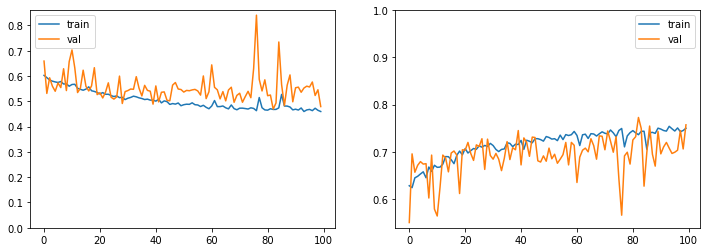

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6059 - accuracy: 0.6013 - precision: 0.9297 - recall: 0.5851 - f1: 0.7003 - specificity: 0.7070 - negative_predictive_value: 0.2137 - matthews_correlation_coefficient: 0.2066 - val_loss: 0.5428 - val_accuracy: 0.6114 - val_precision: 0.9023 - val_recall: 0.5734 - val_f1: 0.6962 - val_specificity: 0.7714 - val_negative_predictive_value: 0.2537 - val_matthews_correlation_coefficient: 0.2262

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22622, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_30-22_35_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5528 - accuracy: 0.6232 - precision: 0.9463 - recall: 0.5965 - f1: 0.7236 - specificity: 0.7696 - negative_predictive_value: 0.2507 - matthews_correlation_coefficient: 0.2662 - val_loss: 0.7184 - val_accuracy: 0.5204 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4745 - accuracy: 0.7245 - precision: 0.9557 - recall: 0.7161 - f1: 0.8126 - specificity: 0.7872 - negative_predictive_value: 0.3263 - matthews_correlation_coefficient: 0.3714 - val_loss: 0.4994 - val_accuracy: 0.7225 - val_precision: 0.9166 - val_recall: 0.6978 - val_f1: 0.7900 - val_specificity: 0.7422 - val_negative_predictive_value: 0.3308 - val_matthews_correlation_coefficient: 0.3263

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35069
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4721 - accuracy: 0.7178 - precision: 0.9538 - recall: 0.7056 - f1: 0.8033 - specificity: 0.7808 - negative_predictive_value: 0.3228 - matthews_correlation_coefficient: 0.3598 - val_loss: 0.4779 - val_accuracy: 0.7303 - val_precision: 0.9106 - val_recall: 0.7134 - val_f1: 0.7976 - val_specificity: 0.7160 - val_negative_predictive_value: 0.3298 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4325 - accuracy: 0.7562 - precision: 0.9602 - recall: 0.7500 - f1: 0.8375 - specificity: 0.8057 - negative_predictive_value: 0.3629 - matthews_correlation_coefficient: 0.4156 - val_loss: 0.3424 - val_accuracy: 0.8187 - val_precision: 0.8877 - val_recall: 0.8468 - val_f1: 0.8657 - val_specificity: 0.5227 - val_negative_predictive_value: 0.4044 - val_matthews_correlation_coefficient: 0.3237

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39888
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4249 - accuracy: 0.7649 - precision: 0.9623 - recall: 0.7563 - f1: 0.8433 - specificity: 0.8245 - negative_predictive_value: 0.3771 - matthews_correlation_coefficient: 0.4374 - val_loss: 0.3895 - val_accuracy: 0.7953 - val_precision: 0.9115 - val_recall: 0.7933 - val_f1: 0.8463 - val_specificity: 0.6888 - val_negative_predictive_value: 0.4012 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.42295 to 0.42327, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_30-22_35_08.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4051 - accuracy: 0.7709 - precision: 0.9667 - recall: 0.7616 - f1: 0.8470 - specificity: 0.8458 - negative_predictive_value: 0.3907 - matthews_correlation_coefficient: 0.4591 - val_loss: 0.3252 - val_accuracy: 0.8413 - val_precision: 0.8817 - val_recall: 0.8852 - val_f1: 0.8824 - val_specificity: 0.4228 - val_negative_predictive_value: 0.4223 - val_matthews_correlation_coefficient: 0.3271

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42327
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3995 - accuracy: 0.7848 - precision: 0.9640 - recall: 0.7800 - f1: 0.8575 - specificity: 0.8314 - negative_predictive_value: 0.4029 - matthews_correlation_coefficient: 0.4646 - val_loss: 0.3869 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3904 - accuracy: 0.7998 - precision: 0.9634 - recall: 0.7958 - f1: 0.8674 - specificity: 0.7999 - negative_predictive_value: 0.4063 - matthews_correlation_coefficient: 0.4672 - val_loss: 0.3910 - val_accuracy: 0.7979 - val_precision: 0.9300 - val_recall: 0.7799 - val_f1: 0.8457 - val_specificity: 0.7999 - val_negative_predictive_value: 0.4212 - val_matthews_correlation_coefficient: 0.4442

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44948
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4138 - accuracy: 0.7785 - precision: 0.9636 - recall: 0.7749 - f1: 0.8515 - specificity: 0.8183 - negative_predictive_value: 0.4060 - matthews_correlation_coefficient: 0.4583 - val_loss: 0.3256 - val_accuracy: 0.8456 - val_precision: 0.8856 - val_recall: 0.8847 - val_f1: 0.8843 - val_specificity: 0.4512 - val_negative_predictive_value: 0.4253 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.47198
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3976 - accuracy: 0.7575 - precision: 0.9679 - recall: 0.7451 - f1: 0.8352 - specificity: 0.8279 - negative_predictive_value: 0.3689 - matthews_correlation_coefficient: 0.4322 - val_loss: 0.3068 - val_accuracy: 0.8725 - val_precision: 0.9124 - val_recall: 0.8869 - val_f1: 0.8983 - val_specificity: 0.6624 - val_negative_predictive_value: 0.5563 - val_matthews_correlation_coefficient: 0.4988

Epoch 00073: val_matthews_correlation_coefficient improved from 0.47198 to 0.49879, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_30-22_35_08.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3652 - accuracy: 0.8026 - precision: 0.9687 - recall: 0.7961 - f1: 0.8708 - specificity: 0.8450 - negative_predictive_value: 0.4244 - matthews_correlation_coefficient: 0.4943 - val_loss: 0.3261 - val_


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.49879
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3902 - accuracy: 0.7683 - precision: 0.9710 - recall: 0.7533 - f1: 0.8424 - specificity: 0.8623 - negative_predictive_value: 0.3850 - matthews_correlation_coefficient: 0.4613 - val_loss: 0.3067 - val_accuracy: 0.8517 - val_precision: 0.9003 - val_recall: 0.8737 - val_f1: 0.8857 - val_specificity: 0.5958 - val_negative_predictive_value: 0.4973 - val_matthews_correlation_coefficient: 0.4248

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.49879
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3620 - accuracy: 0.8026 - precision: 0.9719 - recall: 0.7953 - f1: 0.8698 - specificity: 0.8573 - negative_predictive_value: 0.4314 - matthews_correlation_coefficient: 0.5049 - val_loss: 0.3905 - val_accuracy: 0.7910 - val_precision: 0.9212 - val_recall: 0.7785 - val_f1: 0.8422 - val_spe

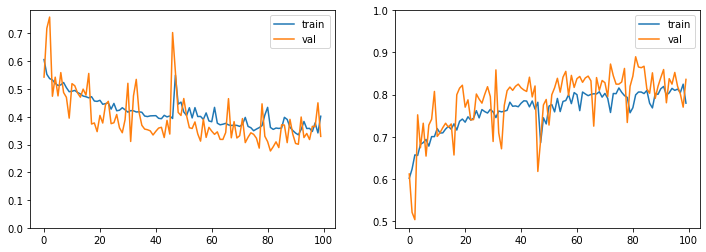

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_30-22_50_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_30-22_50_12.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_30-22_50_12.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



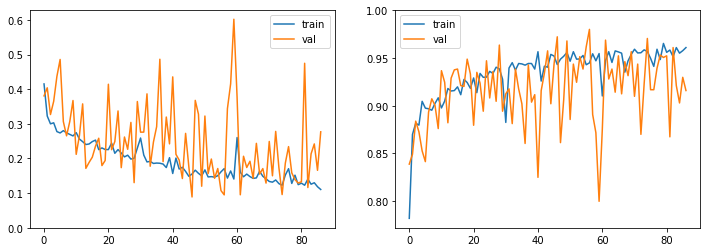

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6127 - accuracy: 0.6260 - precision: 0.8680 - recall: 0.5804 - f1: 0.6763 - specificity: 0.7701 - negative_predictive_value: 0.4139 - matthews_correlation_coefficient: 0.3162 - val_loss: 0.5625 - val_accuracy: 0.6409 - val_precision: 0.8470 - val_recall: 0.5801 - val_f1: 0.6855 - val_specificity: 0.7575 - val_negative_predictive_value: 0.4175 - val_matthews_correlation_coefficient: 0.2978

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29778, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_30-23_03_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5791 - accuracy: 0.6675 - precision: 0.8918 - recall: 0.6264 - f1: 0.7290 - specificity: 0.7788 - negative_predictive_value: 0.4328 - matthews_correlation_coefficient: 0.3625 - val_loss: 0.5619 - val_accuracy: 0.6843 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5432 - accuracy: 0.7111 - precision: 0.8955 - recall: 0.6904 - f1: 0.7736 - specificity: 0.7671 - negative_predictive_value: 0.4669 - matthews_correlation_coefficient: 0.4057 - val_loss: 0.5393 - val_accuracy: 0.6886 - val_precision: 0.8679 - val_recall: 0.6308 - val_f1: 0.7274 - val_specificity: 0.7790 - val_negative_predictive_value: 0.4563 - val_matthews_correlation_coefficient: 0.3634

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36664
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5452 - accuracy: 0.6972 - precision: 0.8986 - recall: 0.6678 - f1: 0.7601 - specificity: 0.7911 - negative_predictive_value: 0.4658 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.6077 - val_accuracy: 0.6548 - val_precision: 0.8750 - val_recall: 0.5715 - val_f1: 0.6867 - val_specificity: 0.8177 - val_negative_predictive_value: 0.4341 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5275 - accuracy: 0.7152 - precision: 0.8967 - recall: 0.6903 - f1: 0.7750 - specificity: 0.7772 - negative_predictive_value: 0.4773 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.5862 - val_accuracy: 0.6852 - val_precision: 0.8433 - val_recall: 0.6485 - val_f1: 0.7301 - val_specificity: 0.7246 - val_negative_predictive_value: 0.4584 - val_matthews_correlation_coefficient: 0.3346

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5219 - accuracy: 0.7204 - precision: 0.9014 - recall: 0.6996 - f1: 0.7827 - specificity: 0.7844 - negative_predictive_value: 0.4862 - matthews_correlation_coefficient: 0.4315 - val_loss: 0.5596 - val_accuracy: 0.6869 - val_precision: 0.8687 - val_recall: 0.6269 - val_f1: 0.7248 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5127 - accuracy: 0.7278 - precision: 0.9016 - recall: 0.6980 - f1: 0.7819 - specificity: 0.7881 - negative_predictive_value: 0.4899 - matthews_correlation_coefficient: 0.4347 - val_loss: 0.5618 - val_accuracy: 0.6938 - val_precision: 0.8626 - val_recall: 0.6439 - val_f1: 0.7347 - val_specificity: 0.7630 - val_negative_predictive_value: 0.4610 - val_matthews_correlation_coefficient: 0.3618

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5131 - accuracy: 0.7232 - precision: 0.9092 - recall: 0.6976 - f1: 0.7852 - specificity: 0.8094 - negative_predictive_value: 0.4897 - matthews_correlation_coefficient: 0.4469 - val_loss: 0.5542 - val_accuracy: 0.6990 - val_precision: 0.8629 - val_recall: 0.6517 - val_f1: 0.7404 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5076 - accuracy: 0.7241 - precision: 0.9083 - recall: 0.6963 - f1: 0.7830 - specificity: 0.7990 - negative_predictive_value: 0.4863 - matthews_correlation_coefficient: 0.4412 - val_loss: 0.5666 - val_accuracy: 0.7034 - val_precision: 0.8628 - val_recall: 0.6596 - val_f1: 0.7449 - val_specificity: 0.7631 - val_negative_predictive_value: 0.4727 - val_matthews_correlation_coefficient: 0.3756

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38294
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5021 - accuracy: 0.7271 - precision: 0.9087 - recall: 0.7035 - f1: 0.7883 - specificity: 0.7938 - negative_predictive_value: 0.4882 - matthews_correlation_coefficient: 0.4419 - val_loss: 0.5151 - val_accuracy: 0.7207 - val_precision: 0.8554 - val_recall: 0.6972 - val_f1: 0.7660 - val_specificity: 0.7212 - val_negative_predictive_value: 0.4852 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4946 - accuracy: 0.7269 - precision: 0.9058 - recall: 0.7014 - f1: 0.7858 - specificity: 0.7838 - negative_predictive_value: 0.4861 - matthews_correlation_coefficient: 0.4353 - val_loss: 0.5272 - val_accuracy: 0.7199 - val_precision: 0.8636 - val_recall: 0.6838 - val_f1: 0.7613 - val_specificity: 0.7569 - val_negative_predictive_value: 0.4867 - val_matthews_correlation_coefficient: 0.3918

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39261
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4907 - accuracy: 0.7373 - precision: 0.9141 - recall: 0.7121 - f1: 0.7961 - specificity: 0.8121 - negative_predictive_value: 0.5058 - matthews_correlation_coefficient: 0.4672 - val_loss: 0.5869 - val_accuracy: 0.6843 - val_precision: 0.8607 - val_recall: 0.6318 - val_f1: 0.7254 - val_specificity: 0.7706 - val_negative_predictive_value: 0.4563 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.39408
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4874 - accuracy: 0.7401 - precision: 0.9141 - recall: 0.7144 - f1: 0.7966 - specificity: 0.8223 - negative_predictive_value: 0.5054 - matthews_correlation_coefficient: 0.4740 - val_loss: 0.6264 - val_accuracy: 0.6739 - val_precision: 0.8919 - val_recall: 0.5903 - val_f1: 0.7058 - val_specificity: 0.8509 - val_negative_predictive_value: 0.4525 - val_matthews_correlation_coefficient: 0.3880

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39408
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4921 - accuracy: 0.7254 - precision: 0.9117 - recall: 0.6975 - f1: 0.7824 - specificity: 0.8096 - negative_predictive_value: 0.4902 - matthews_correlation_coefficient: 0.4513 - val_loss: 0.5348 - val_accuracy: 0.7138 - val_precision: 0.8580 - val_recall: 0.6843 - val_f1: 0.7585 - val_spe

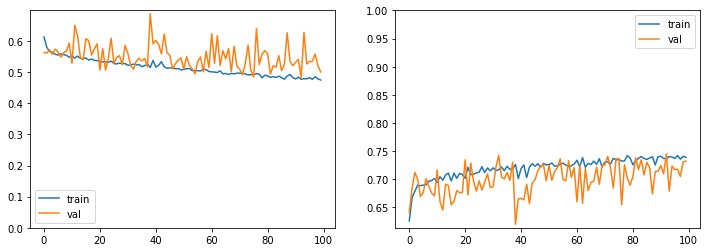

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4378 - accuracy: 0.7833 - precision: 0.9979 - recall: 0.7838 - f1: 0.8695 - specificity: 0.2563 - negative_predictive_value: 0.0455 - matthews_correlation_coefficient: 0.0875 - val_loss: 0.6699 - val_accuracy: 0.6895 - val_precision: 0.9990 - val_recall: 0.6955 - val_f1: 0.8166 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0284 - val_matthews_correlation_coefficient: 0.0666

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06659, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_30-23_18_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3219 - accuracy: 0.8382 - precision: 0.9993 - recall: 0.8384 - f1: 0.9104 - specificity: 0.2736 - negative_predictive_value: 0.0654 - matthews_correlation_coefficient: 0.1204 - val_loss: 0.1427 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2345 - accuracy: 0.8690 - precision: 0.9995 - recall: 0.8657 - f1: 0.9260 - specificity: 0.2862 - negative_predictive_value: 0.0740 - matthews_correlation_coefficient: 0.1319 - val_loss: 0.5913 - val_accuracy: 0.7034 - val_precision: 0.9990 - val_recall: 0.7091 - val_f1: 0.8251 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0289 - val_matthews_correlation_coefficient: 0.0676

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.14195
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2454 - accuracy: 0.8356 - precision: 0.9995 - recall: 0.8354 - f1: 0.9086 - specificity: 0.2897 - negative_predictive_value: 0.0584 - matthews_correlation_coefficient: 0.1167 - val_loss: 0.2685 - val_accuracy: 0.8873 - val_precision: 0.9992 - val_recall: 0.8900 - val_f1: 0.9401 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0886 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2280 - accuracy: 0.8427 - precision: 0.9997 - recall: 0.8424 - f1: 0.9130 - specificity: 0.2931 - negative_predictive_value: 0.0622 - matthews_correlation_coefficient: 0.1215 - val_loss: 0.2430 - val_accuracy: 0.8673 - val_precision: 0.9991 - val_recall: 0.8704 - val_f1: 0.9287 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0851 - val_matthews_correlation_coefficient: 0.1291

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.14195
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2169 - accuracy: 0.8711 - precision: 0.9998 - recall: 0.8708 - f1: 0.9299 - specificity: 0.2690 - negative_predictive_value: 0.0788 - matthews_correlation_coefficient: 0.1296 - val_loss: 0.2213 - val_accuracy: 0.8899 - val_precision: 0.9991 - val_recall: 0.8925 - val_f1: 0.9416 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0883 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2051 - accuracy: 0.8677 - precision: 1.0000 - recall: 0.8671 - f1: 0.9276 - specificity: 0.2966 - negative_predictive_value: 0.0759 - matthews_correlation_coefficient: 0.1363 - val_loss: 0.2667 - val_accuracy: 0.8881 - val_precision: 0.9991 - val_recall: 0.8908 - val_f1: 0.9406 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0874 - val_matthews_correlation_coefficient: 0.1315

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.15302
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2140 - accuracy: 0.8601 - precision: 0.9995 - recall: 0.8600 - f1: 0.9232 - specificity: 0.3000 - negative_predictive_value: 0.0733 - matthews_correlation_coefficient: 0.1337 - val_loss: 0.2406 - val_accuracy: 0.8985 - val_precision: 0.9991 - val_recall: 0.9011 - val_f1: 0.9464 - val_specificity: 0.2432 - val_negative_predictive_value: 0.1059 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1812 - accuracy: 0.8818 - precision: 0.9997 - recall: 0.8816 - f1: 0.9359 - specificity: 0.2759 - negative_predictive_value: 0.0824 - matthews_correlation_coefficient: 0.1385 - val_loss: 0.2009 - val_accuracy: 0.9185 - val_precision: 0.9992 - val_recall: 0.9207 - val_f1: 0.9575 - val_specificity: 0.2432 - val_negative_predictive_value: 0.1122 - val_matthews_correlation_coefficient: 0.1530

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.15302
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1926 - accuracy: 0.8855 - precision: 0.9995 - recall: 0.8853 - f1: 0.9379 - specificity: 0.2759 - negative_predictive_value: 0.0819 - matthews_correlation_coefficient: 0.1352 - val_loss: 0.4028 - val_accuracy: 0.8127 - val_precision: 0.9991 - val_recall: 0.8165 - val_f1: 0.8962 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0467 - val_matthews_correlation_coefficie

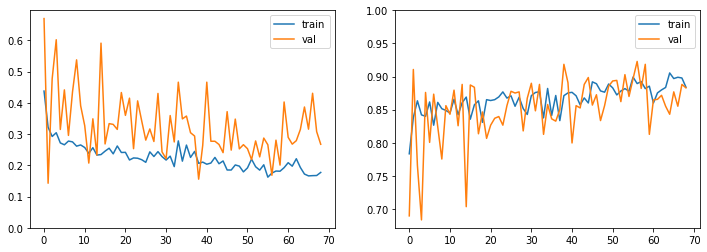

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_30-18_42_47.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_30-18_57_40.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_30-19_07_11.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_30-19_19_53.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_30-19_33_00.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_30-19_45_03.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_30-19_54_08.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_30-20_08_52.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_30-20_23_02.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_30-20_37_50.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_30-20_43_52.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_30-20_58_16.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_30-21_13_14.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.9999969]], dtype=float32),
 array([[0.5559993]], dtype=float32),
 array([[0.99250937]], dtype=float32),
 array([[0.9797545]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9985814]], dtype=float32),
 array([[0.87705755]], dtype=float32),
 array([[0.5138187]], dtype=float32),
 array([[0.63111407]], dtype=float32),
 array([[0.8015859]], dtype=float32),
 array([[0.5969541]], dtype=float32),
 array([[0.66698515]], dtype=float32),
 array([[0.99999714]], dtype=float32),
 array([[0.9955923]], dtype=float32),
 array([[0.9549063]], dtype=float32),
 array([[0.12775256]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9240353]], dtype=float32),
 array([[0.99987745]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.64612687]], dtype=float32),
 array([[1.]], dtype=float32)]